In [1]:
import numpy as np
import matplotlib.pyplot as plt
import subprocess
from pathlib import Path
import torch
import torch.nn as nn
import torch.optim as optim
import plumed
from scipy.interpolate import griddata

torch.manual_seed(42)

In [2]:
transitionAB=plumed.read_as_pandas("./ABMD_2Levels/COLVAR_ratchetAB1")
transitionAB

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt8equal_toISD_ESaISt4pairIKSD_S4_EEE +++
+++ This error is expected if you are trying to load a kernel <=2.4
+++ Trying /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumed.so +++


time    phi1    phi2    phi3    psi1    psi2    psi3  abmd.bias  \
0    0.000  1.4301 -1.0556 -1.2035 -1.3319 -0.6971  1.3813     0.0000   
1    0.002  1.4321 -1.0489 -1.1961 -1.3369 -0.7075  1.3771     0.0072   
2    0.004  1.4366 -1.0328 -1.1807 -1.3491 -0.7327  1.3689     0.0735   
3    0.006  1.4386 -1.0128 -1.1666 -1.3631 -0.7649  1.3641     0.1266   
4    0.008  1.4358 -0.9915 -1.1587 -1.3758 -0.7999  1.3671     0.0608   
..     ...     ...     ...     ...     ...     ...     ...        ...   
430  0.860 -1.2676 -1.0083 -1.2616  0.7173 -0.5576  1.0734     0.1752   
431  0.862 -1.2580 -1.0200 -1.2523  0.7254 -0.5374  1.0489     0.1931   
432  0.864 -1.2439 -1.0285 -1.2356  0.7310 -0.5266  1.0273     0.2276   
433  0.866 -1.2252 -1.0327 -1.2142  0.7326 -0.5246  1.0114     0.2909   
434  0.868 -1.2030 -1.0312 -1.1925  0.7287 -0.5311  1.0050     0.3912   

     abmd.phi1_min  abmd.phi2_min  abmd.phi3_min  abmd.force2  
0           8.5853          0.002         0.0107       0.0000  
1           8.5853          0.002         0.0092      49.7174  
2           8.5853          0.002         0.0065     504.8668  
3           8.5853          0.002         0.0044     863.6884  
4           8.5853          0.002         0.0034     386.4008  
..             ...            ...            ...          ...  
430         0.0000          0.000         0.0034       6.8681  
431         0.0000          0.000         0.0034       8.4095  
432         0.0000          0.000         0.0034      11.4539  
433         0.0000          0.000         0.0034      17.2859  
434         0.0000          0.000         0.0034      27.4409  

[435 rows x 12 columns]

In [3]:
from skmatter.feature_selection import FPS

transitionAB1=plumed.read_as_pandas("./ABMD_2Levels/COLVAR_ratchetAB1")
transitionAB2=plumed.read_as_pandas("./ABMD_2Levels/COLVAR_ratchetAB2")
transitionAB3=plumed.read_as_pandas("./ABMD_2Levels/COLVAR_ratchetAB3")
transitionAB4=plumed.read_as_pandas("./ABMD_2Levels/COLVAR_ratchetAB4")
transitionAB5=plumed.read_as_pandas("./ABMD_2Levels/COLVAR_ratchetAB5")
transitionBC1=plumed.read_as_pandas("./ABMD_2Levels/COLVAR_ratchetBC1")
transitionBC2=plumed.read_as_pandas("./ABMD_2Levels/COLVAR_ratchetBC2")
transitionBC3=plumed.read_as_pandas("./ABMD_2Levels/COLVAR_ratchetBC3")
transitionBC4=plumed.read_as_pandas("./ABMD_2Levels/COLVAR_ratchetBC4")
transitionBC5=plumed.read_as_pandas("./ABMD_2Levels/COLVAR_ratchetBC5")
transitionBA1=plumed.read_as_pandas("./ABMD_2Levels/COLVAR_ratchetBA1")
transitionBA2=plumed.read_as_pandas("./ABMD_2Levels/COLVAR_ratchetBA2")
transitionBA3=plumed.read_as_pandas("./ABMD_2Levels/COLVAR_ratchetBA3")
transitionBA4=plumed.read_as_pandas("./ABMD_2Levels/COLVAR_ratchetBA4")
transitionBA5=plumed.read_as_pandas("./ABMD_2Levels/COLVAR_ratchetBA5")

training_batches=np.vstack((transitionAB1.iloc[:,1:7],
                            transitionAB2.iloc[:,1:7],
                            transitionAB3.iloc[:,1:7],
                            transitionAB4.iloc[:,1:7],
                            transitionAB5.iloc[:,1:7],
                            transitionBC1.iloc[:,1:7],
                            transitionBC2.iloc[:,1:7],
                            transitionBC3.iloc[:,1:7],
                            transitionBC4.iloc[:,1:7],
                            transitionBC5.iloc[:,1:7],
                            transitionBA1.iloc[:,1:7],
                            transitionBA2.iloc[:,1:7],
                            transitionBA3.iloc[:,1:7],
                            transitionBA4.iloc[:,1:7],
                            transitionBA5.iloc[:,1:7])
                          )
   
print(training_batches.shape)
selector = FPS(n_to_select=1000,initialize=0)

selector.fit(training_batches[:,:3].T)
r_ndx=selector.selected_idx_

training_datapoints =training_batches[r_ndx,:]
training_datapoints.shape

(12483, 6)


+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt8equal_toISD_ESaISt4pairIKSD_S4_EEE +++
+++ This error is expected if you are trying to load a kernel <=2.4
+++ Trying /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumed.so +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt

(1000, 6)

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt8equal_toISD_ESaISt4pairIKSD_S4_EEE +++
+++ This error is expected if you are trying to load a kernel <=2.4
+++ Trying /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumed.so +++


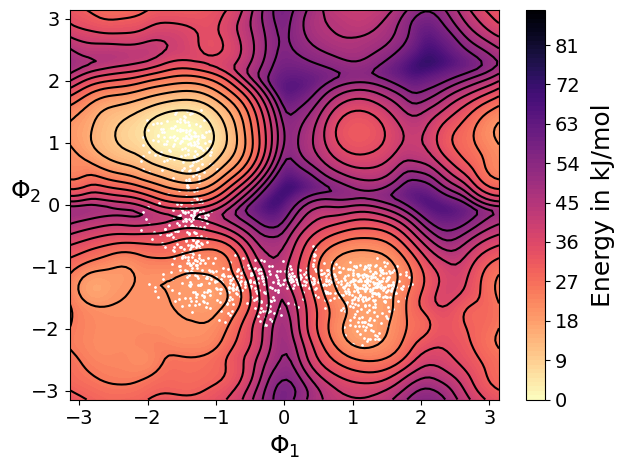

<Figure size 640x480 with 0 Axes>

In [4]:
data=plumed.read_as_pandas("fes-rew_phi1phi2.dat" )

phi_forward=training_datapoints[:,0]
psi_forward=training_datapoints[:,1]
    
phi_values = data['phi1']
psi_values = data['phi2']
file_free_values = data['file.free']

phi_grid, psi_grid = np.meshgrid(np.linspace(phi_values.min(), phi_values.max(), 100),
                                 np.linspace(psi_values.min(), psi_values.max(), 100))

file_free_grid = griddata((phi_values, psi_values), file_free_values, (phi_grid, psi_grid), method='cubic')

levels=np.arange(0,90,1)
s = plt.contourf(phi_grid, psi_grid, file_free_grid,levels, cmap='magma_r')

levels=np.arange(0,60,5)
plt.contour(phi_grid, psi_grid,file_free_grid,levels,colors='black')

plt.scatter(phi_forward,psi_forward,c='white',s=1)

cbar = plt.colorbar(s, shrink=1)
cbar.set_label(r'Energy in kJ/mol', rotation=90, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$\Phi_1$',fontsize=18)
plt.ylabel(r'$\Phi_2$',fontsize=18,rotation=0)
plt.tight_layout()
plt.show()


plt.tight_layout()
plt.show()

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt8equal_toISD_ESaISt4pairIKSD_S4_EEE +++
+++ This error is expected if you are trying to load a kernel <=2.4
+++ Trying /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumed.so +++


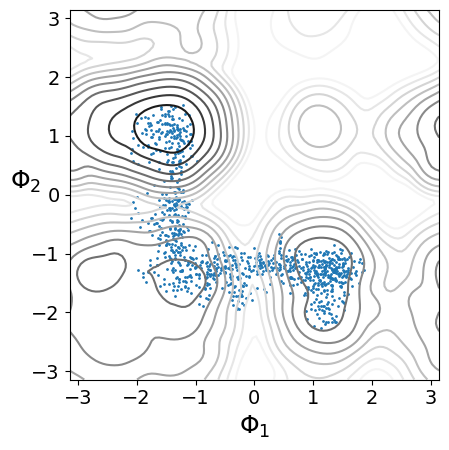

In [5]:
data=plumed.read_as_pandas("fes-rew_phi1phi2.dat" )

phi_forward=training_datapoints[:,0]
psi_forward=training_datapoints[:,1]
    
phi_values = data['phi1']
psi_values = data['phi2']
file_free_values = data['file.free']

phi_grid, psi_grid = np.meshgrid(np.linspace(phi_values.min(), phi_values.max(), 100),
                                 np.linspace(psi_values.min(), psi_values.max(), 100))

file_free_grid = griddata((phi_values, psi_values), file_free_values, (phi_grid, psi_grid), method='cubic')


fig, ax = plt.subplots(dpi=100)                  
ax.contour(phi_grid, psi_grid, file_free_grid,levels, cmap='Greys_r')
ax.set_aspect('equal')
pp=ax.scatter(phi_forward,psi_forward,s=1)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$\Phi_1$',fontsize=18)
plt.ylabel(r'$\Phi_2$',fontsize=18,rotation=0)
plt.show()

(300, 6)


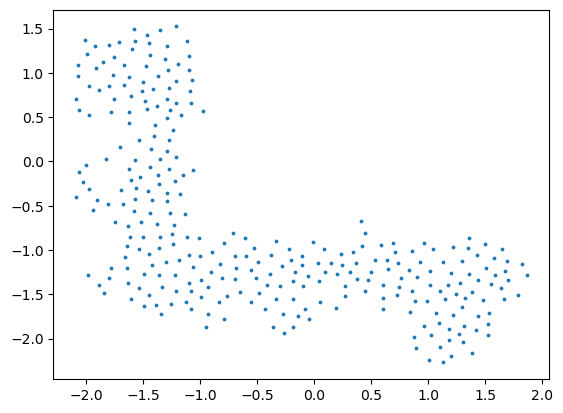

In [6]:
from skmatter.feature_selection import FPS

selector = FPS(n_to_select=300,initialize=0)

selector.fit(training_datapoints[:,:2].T)
r_ndx=selector.selected_idx_

model_datapoints =training_datapoints[r_ndx,:]

print(model_datapoints.shape)

plt.figure()
plt.scatter(model_datapoints[:,0],model_datapoints[:,1],s=3,alpha=1)
plt.show()

In [7]:
labels = np.full(training_datapoints.shape[0], 2.0)

center1 = np.array([1.6, -1.1])
center1_2 = np.array([1.6, -2])
center2 = np.array([-1.3, -1.3])
center3 = np.array([-1.5, 1.7])

r1 = 0.7
r1_2 = 0.7
r2 = 0.6
r3 = 0.8

distances_center1 = np.linalg.norm(training_datapoints[:,:2] - center1, axis=1)
distances_center1_2 = np.linalg.norm(training_datapoints[:,:2] - center1_2, axis=1)
distances_center2 = np.linalg.norm(training_datapoints[:,:2] - center2, axis=1)
distances_center3 = np.linalg.norm(training_datapoints[:,:2] - center3, axis=1)

indices_center1 = np.where(distances_center1 < r1)
labels[indices_center1] = 0

indices_center1_2 = np.where(distances_center1_2 < r1_2)
labels[indices_center1_2] = 0

indices_center2 = np.where(distances_center2 < r2)
labels[indices_center2] = 0.5

indices_center3 = np.where(distances_center3 < r3)
labels[indices_center3] = 1


training_datapoints_labels=labels
training_datapoints_labels.shape

(1000,)

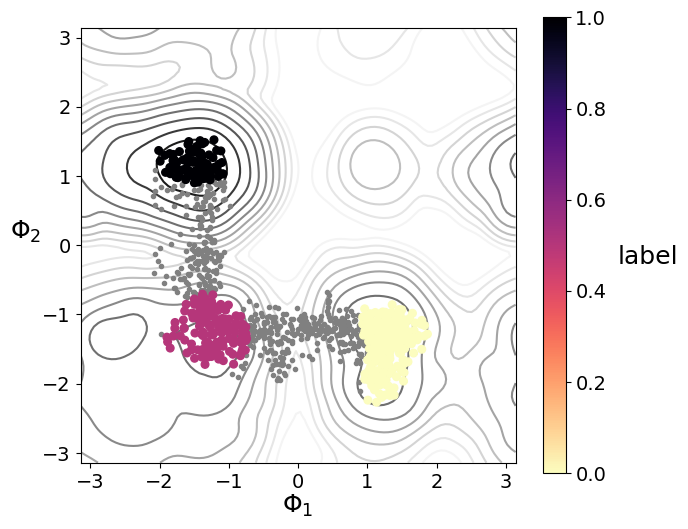

In [8]:
fig, ax = plt.subplots(1, figsize=(7,7))          
ax.contour(phi_grid, psi_grid, file_free_grid,levels, cmap='Greys_r')
ax.set_aspect('equal')
ax.plot(training_datapoints[:,0],training_datapoints[:,1],'o', color='gray',markersize=3)
ndx=np.where((training_datapoints_labels!=2.0))[0]
pp=ax.scatter(training_datapoints[ndx,0],training_datapoints[ndx,1],c=training_datapoints_labels[ndx],s=30,cmap='magma_r',zorder=20)
cbar = plt.colorbar(pp, ax=ax, shrink=0.7)
cbar.ax.set_position([0.78, 0.11, 0.05, 0.77]) 
cbar.set_label(r'label', rotation=0, labelpad=30,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$\Phi_1$',fontsize=18,labelpad=1)
plt.ylabel(r'$\Phi_2$', rotation=0,fontsize=18,labelpad=12)
plt.tight_layout()
plt.show()

In [9]:
print(training_datapoints.shape)
print(model_datapoints.shape)
print(training_datapoints_labels.shape)

(1000, 6)
(300, 6)
(1000,)


In [10]:
print(np.isnan(training_datapoints))
print(np.isnan(training_datapoints_labels))

[[False False False False False False]
 [False False False False False False]
 [False False False False False False]
 ...
 [False False False False False False]
 [False False False False False False]
 [False False False False False False]]
[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False

In [11]:
from torch.utils.data import TensorDataset, DataLoader

dataset = TensorDataset(torch.Tensor(training_datapoints), torch.Tensor(training_datapoints_labels))

In [12]:
device = torch.device("cpu")

In [13]:
from torch.utils.data import Subset
from torch.utils.data.dataset import random_split

torch.manual_seed(42)  
shuffle_dataset = True

dataset_size = len(dataset)
indices = list(range(dataset_size))
if shuffle_dataset:
    np.random.shuffle(indices)

# Split dataset into training and validation sets
train_size = int(0.8 * dataset_size)  # 80% for training, 20% for validation
val_size = dataset_size - train_size
train_indices, val_indices = indices[:train_size], indices[train_size:]
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

# Define batch size for training
batch_size_train = 64

# Create DataLoader for training set
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)

# Load entire validation dataset as one big batch
val_features = []
val_labels = []
for val_index in val_indices:
    feature, label = dataset[val_index]
    val_features.append(feature)
    val_labels.append(label)

val_features = torch.stack(val_features)  # Stack features into one big tensor
val_labels = torch.stack(val_labels)  # Stack labels into one big tensor

# Convert to tensor and move to device if necessary
val_features = val_features.to(device)
val_labels = val_labels.to(device)
val_features.shape

torch.Size([200, 6])

In [14]:
for batch_idx, (features, labels) in enumerate(train_loader):
    if batch_idx == 0 :
        print(features.shape)
        print(labels.shape)
batch_size_train*batch_idx

torch.Size([64, 6])
torch.Size([64])


768

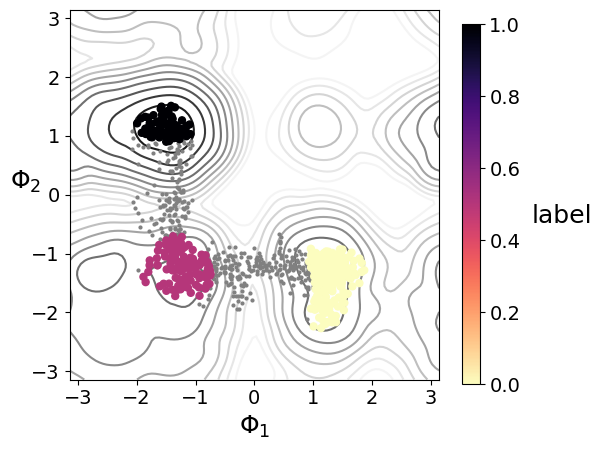

In [15]:
fig, ax = plt.subplots(dpi=100)                  
ax.contour(phi_grid, psi_grid, file_free_grid,levels, cmap='Greys_r')
ax.set_aspect('equal')
plt.plot(train_dataset[:][0][:,0],train_dataset[:][0][:,1],'o', color='gray',linewidth=1, markersize=2)
ndx=np.where((train_dataset[:][1]!=2.0))[0]
plt.scatter(train_dataset[:][0][ndx,0],train_dataset[:][0][ndx,1],c=train_dataset[:][1][ndx],s=25,cmap='magma_r',zorder=20)
cbar = plt.colorbar(pp, ax=ax)
cbar.ax.set_position([0.78, 0.1, 0.05, 0.75]) 
cbar.set_label(r'label', rotation=0, labelpad=30,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$\Phi_1$',fontsize=18)
plt.ylabel(r'$\Phi_2$',fontsize=18,rotation=0)
plt.show()

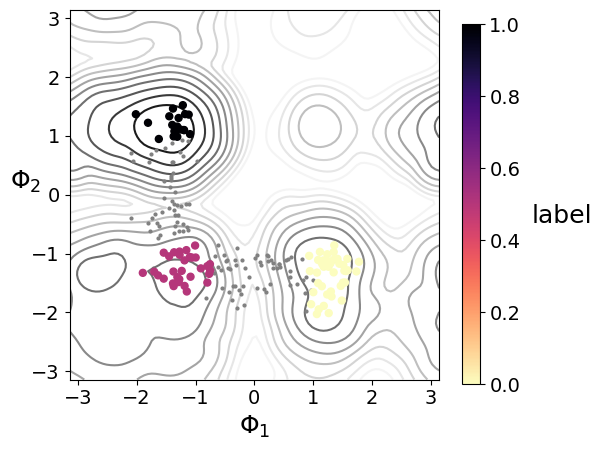

In [16]:
fig, ax = plt.subplots(dpi=100)                  
ax.contour(phi_grid, psi_grid, file_free_grid,levels, cmap='Greys_r')
ax.set_aspect('equal')
plt.plot(val_dataset[:][0][:,0],val_dataset[:][0][:,1],'o', color='gray',linewidth=1, markersize=2)
ndx=np.where((val_dataset[:][1]!=2.0))[0]
plt.scatter(val_dataset[:][0][ndx,0],val_dataset[:][0][ndx,1],c=val_dataset[:][1][ndx],s=25,cmap='magma_r',zorder=20)
cbar = plt.colorbar(pp, ax=ax)
cbar.ax.set_position([0.78, 0.1, 0.05, 0.75])  
cbar.set_label(r'label', rotation=0, labelpad=30,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$\Phi_1$',fontsize=18)
plt.ylabel(r'$\Phi_2$',fontsize=18,rotation=0)
plt.show()

In [17]:
class DeepLNE_CV(nn.Module):

    def __init__(self,
                ANN_layers: list,
                AutoEncoder_layers: list,
                f: int,
                d: int,
                n: int,
                ref: torch.Tensor,
                ref_z: torch.Tensor,
                act: str,
                z_lambda: float,
                device: str):
        

        super(DeepLNE_CV,self).__init__()
        
        # =======   LOSS  =======
        self.loss_mse = torch.nn.MSELoss()
        self.loss_ce = torch.nn.CrossEntropyLoss()
        

        # ======= BLOCKS =======
        
        self.n_features=f
        self.n_neighbors=n
        self.d_metric=d
        self.training_datapoints=ref
        self.training_datapoints_z=ref_z
        self.z_lambda=z_lambda
        
        self.device = torch.device(device)
        
        #print('Numer of input features:',self.n_features)
        #print('Numer of neighbors:',self.n_neighbors)
        #print('Dimension for nn search:',self.d_metric)
         
        if act == 'ReLU':
            self.activationf=torch.nn.ReLU()
        if act == 'Tanh':
            self.activationf=torch.nn.Tanh()
        if act == 'Sigmoid':
            self.activationf=torch.nn.Sigmoid()
        if act == 'ELU':
            self.activationf=torch.nn.ELU()
        if act == 'Softplus':    
            self.activationf=torch.nn.Softplus()
            
        self.ANNlayers = []
        
        self.ANNlayers.append(torch.nn.Linear(self.n_features, ANN_layers[0]))
        self.ANNlayers.append(self.activationf)
        
        for i in range(len(ANN_layers) - 1):
            self.ANNlayers.append(torch.nn.Linear(ANN_layers[i], ANN_layers[i + 1]))
            self.ANNlayers.append(self.activationf)

        self.ANNlayers.append(torch.nn.Linear(ANN_layers[-1], self.d_metric))
        
        self.metric = torch.nn.Sequential(*self.ANNlayers).to(self.device)
        #print('ANN architecture: ',self.metric)
            

        # initialize encoder
        self.AutoEncoderLayers = []
        
        self.AutoEncoderLayers.append(torch.nn.Linear(int(self.n_neighbors*self.d_metric), AutoEncoder_layers[0]))
        self.AutoEncoderLayers.append(self.activationf)
        
        for i in range(len(AutoEncoder_layers) - 1):
            self.AutoEncoderLayers.append(torch.nn.Linear(AutoEncoder_layers[i], AutoEncoder_layers[i + 1]))
            self.AutoEncoderLayers.append(self.activationf)

        self.AutoEncoderLayers.append(torch.nn.Linear(AutoEncoder_layers[-1], 1))
        self.AutoEncoderLayers.append(torch.nn.Sigmoid())

        self.encoder = torch.nn.Sequential(*self.AutoEncoderLayers).to(self.device)
        #print('Encoder architecture: ',self.encoder)
        
        # initialize decoder
        self.AutoDecoderLayers = []
        AutoDecoder_layers=AutoEncoder_layers[::-1]
        
        self.AutoDecoderLayers.append(torch.nn.Linear(1, AutoDecoder_layers[0]))
        self.AutoDecoderLayers.append(self.activationf)
        
        for i in range(len(AutoDecoder_layers) - 1):
            self.AutoDecoderLayers.append(torch.nn.Linear(AutoDecoder_layers[i], AutoDecoder_layers[i + 1]))
            self.AutoDecoderLayers.append(self.activationf)

        self.AutoDecoderLayers.append(torch.nn.Linear(AutoDecoder_layers[-1], self.n_features))

        self.decoder = torch.nn.Sequential(*self.AutoDecoderLayers).to(self.device)
        #print('Decoder architecture: ',self.decoder)
    
    def softmax_w(self,x: torch.Tensor, t=1e-1) -> torch.Tensor:
        x = x / t
        x = x - torch.max(x, dim=1, keepdim=True)[0]
        return (torch.exp(x)+1e-6) / torch.sum(torch.exp(x), dim=1, keepdim=True)
        

    def soft_top_k(self,x: torch.Tensor,t: torch.Tensor) -> torch.Tensor:
        y = torch.zeros_like(x)
            
        for k in range(self.n_neighbors):
            y.fill_diagonal_(1)
            x_w = x * (1 - y)
            x_w_softmax = self.softmax_w(x_w)
            y = y+x_w_softmax
            
            dm=torch.matmul(t.T,x_w_softmax.T)
            
            if k == 0:
                dn=dm
            else:
                dn=torch.cat((dn,dm))
        return dn.T

    def learn_metric(self,x: torch.Tensor) -> torch.Tensor:
        d=self.metric(x)
        t=self.metric(self.training_datapoints)
        return d,t
    
    def find_nearest_neighbors(self,x: torch.Tensor,t: torch.Tensor) -> torch.Tensor:
        
        dist = torch.cdist(x, t)
        dist=torch.exp(-dist)
        dn = self.soft_top_k(dist,t)
        
        return dn
        
    def encode(self,x: torch.Tensor) -> torch.Tensor:
        x=self.encoder(x)
        return x
    
    def decode(self,x: torch.Tensor) -> torch.Tensor:
        x=self.decoder(x)
        return x
    
    def encode_decode(self, x: torch.Tensor) -> torch.Tensor:
        d,t=self.learn_metric(x)
        dn=self.find_nearest_neighbors(d,t)
        
        s=self.encode(dn)
        x_hat=self.decode(s) 
        
        return x_hat,s,d,dn
    
    def forward(self, x: torch.Tensor) -> torch.Tensor :
        d,t=self.learn_metric(x)
        dn=self.find_nearest_neighbors(d,t)
        s=self.encode(dn).reshape(-1,1)
        z=self.compute_z(x[:,:2]).reshape(-1,1) #self.compute_z(d).reshape(-1,1)
        
        out=torch.hstack((s,z))
        
        return out
    
    def compute_z(self,x: torch.Tensor) -> torch.Tensor:
        z_dist=torch.cdist(x,self.training_datapoints_z[:,:2])
        z_dist=torch.absolute(z_dist)
        z=(-1/self.z_lambda)*torch.log(torch.sum(torch.exp(-self.z_lambda*z_dist),axis=1))

        return z

In [18]:
device = torch.device("cuda") #("cpu") #("cuda")

training_datapoints=torch.Tensor(training_datapoints).to(device)
model_datapoints=torch.Tensor(model_datapoints).to(device)

ANN_architecture=[3]
AutoEncoder_architecture=[2]

n_features=6
d_metric=3
n_neighbors=3 
l=10

model = DeepLNE_CV(ANN_layers=ANN_architecture,
                   AutoEncoder_layers=AutoEncoder_architecture,
                   f=n_features,
                   d=d_metric,
                   n=n_neighbors,
                   ref=model_datapoints,
                   ref_z=model_datapoints,
                   act='Tanh',
                   z_lambda=l,
                   device=device)

optimizer = optim.Adam(model.parameters(), lr=0.001)

In [30]:
alpha=1e0
beta=1e-4


track_train = []
track_val = []
best_val_loss = float('inf')  

num_epochs = 5001
for epoch in range(num_epochs):
    train_loss = 0.0
    model.train()  # Set the model to training mode
    for batch_idx, (features, labels) in enumerate(train_loader):
        # Prepare input and target data
        x = features.to(device)  
        l = labels.to(device) 
        
        # Forward Pass
        x_hat,s,d,dn = model.encode_decode(x)

        # Compute Loss
        #selective reconstruction
        reconstruction_loss = model.loss_mse(x_hat[:,:2], x[:,:2])
        
        ndx=torch.where(l!=2)[0]
        if len(ndx) > 0:
            multitask_loss = model.loss_mse(s.flatten()[ndx], l[ndx])
        else:
            multitask_loss = 0.0
        loss=reconstruction_loss+alpha*multitask_loss
        
        #L2 regularization
        for param in model.parameters():
            loss += beta * torch.norm(param, 2)

        # Backward Pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item() * x.size(0)

    train_loss = train_loss / batch_idx
    track_train.append(train_loss)
    
    # Validation phase
    model.eval()  # Set the model to evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        
        val_x = val_features.to(device)
        val_l = val_labels.to(device)

        # Forward Pass
        x_hat,s,d,dn = model.encode_decode(val_x)

        # Compute Loss
        #selective reconstrction
        reconstruction_loss = model.loss_mse(x_hat[:,:2], val_x[:,:2])
        
        ndx=torch.where(val_l!=2)[0]
        if len(ndx) > 0:
            multitask_loss = model.loss_mse(s.flatten()[ndx], val_l[ndx])
        else:
            multitask_loss = 0.0
        loss=reconstruction_loss+alpha*multitask_loss
        
    val_loss += loss.item() * val_x.size(0)

    track_val.append(val_loss)
    
    if epoch % 100 == 0:
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, val_loss))

    # Save the best model based on validation loss
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), './DeepLNE_3states/model_teacher.pt')

    # Break early if necessary
    if train_loss < 1e-5:
        print(f"Converged at epoch {epoch}")
        break


Epoch: 0 	Training Loss: 125.670050 	Validation Loss: 367.568612
Epoch: 100 	Training Loss: 47.554565 	Validation Loss: 133.396888
Epoch: 200 	Training Loss: 9.070011 	Validation Loss: 23.296459
Epoch: 300 	Training Loss: 4.959458 	Validation Loss: 12.689409
Epoch: 400 	Training Loss: 3.343253 	Validation Loss: 8.958151
Epoch: 500 	Training Loss: 3.178328 	Validation Loss: 8.681646
Epoch: 600 	Training Loss: 3.156930 	Validation Loss: 8.611670
Epoch: 700 	Training Loss: 3.125187 	Validation Loss: 8.489369
Epoch: 800 	Training Loss: 3.103357 	Validation Loss: 8.403531
Epoch: 900 	Training Loss: 3.098107 	Validation Loss: 8.350073
Epoch: 1000 	Training Loss: 3.083605 	Validation Loss: 8.309436
Epoch: 1100 	Training Loss: 3.068047 	Validation Loss: 8.254123
Epoch: 1200 	Training Loss: 3.064468 	Validation Loss: 8.235793
Epoch: 1300 	Training Loss: 3.059693 	Validation Loss: 8.273515
Epoch: 1400 	Training Loss: 3.052987 	Validation Loss: 8.172899
Epoch: 1500 	Training Loss: 3.048215 	Valid

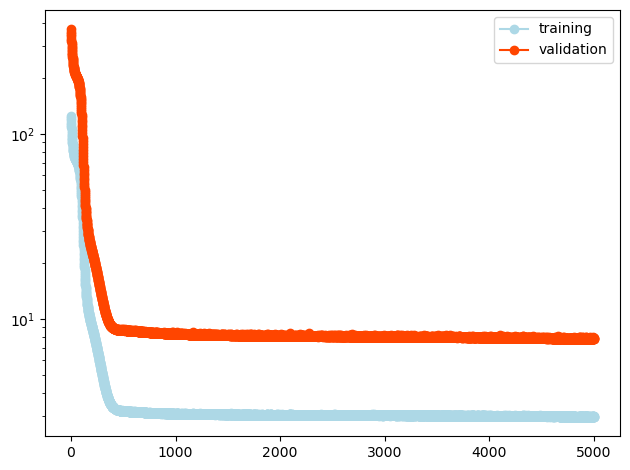

In [31]:
plt.figure()
plt.plot(track_train,'o-',color='lightblue',label='training')
plt.plot(track_val,'o-',color='orangered',label='validation')
plt.yscale('log')
plt.legend()
plt.tight_layout()
plt.show()

In [19]:
device = torch.device("cpu")

training_datapoints=torch.Tensor(training_datapoints).to(device)
model_datapoints=torch.Tensor(model_datapoints).to(device)

ANN_architecture=[3]
AutoEncoder_architecture=[2] 

model = DeepLNE_CV(ANN_layers=ANN_architecture,
                   AutoEncoder_layers=AutoEncoder_architecture,
                   f=n_features,
                   d=d_metric,
                   n=n_neighbors,
                   ref=model_datapoints,
                   ref_z=model_datapoints,
                   act='Tanh',
                   z_lambda=l,
                   device=device)

model.load_state_dict(torch.load('./DeepLNE_3states/model_teacher.pt'), strict=False)
model_datapoints_z=model.encode_decode(model_datapoints)[0].detach().numpy()

training_datapoints=torch.Tensor(training_datapoints)
model_datapoints=torch.Tensor(model_datapoints)
model_datapoints_z=torch.Tensor(model_datapoints_z)

ANN_architecture=[3]
AutoEncoder_architecture=[2] 

n_features=6
d_metric=3
n_neighbors=3
l=10 #7e1

plumed_model = DeepLNE_CV(ANN_layers=ANN_architecture,
                   AutoEncoder_layers=AutoEncoder_architecture,
                   f=n_features,
                   d=d_metric,
                   n=n_neighbors,
                   ref=model_datapoints,
                   ref_z=model_datapoints_z,
                   act='Tanh',
                   z_lambda=l,
                   device=device)

plumed_model.load_state_dict(torch.load('./DeepLNE_3states/model_teacher.pt'), strict=False)

<All keys matched successfully>

In [896]:
m=torch.jit.trace(plumed_model,torch.ones(1,n_features))
m.save('./DeepLNE_3states/model_teacher.ptc')

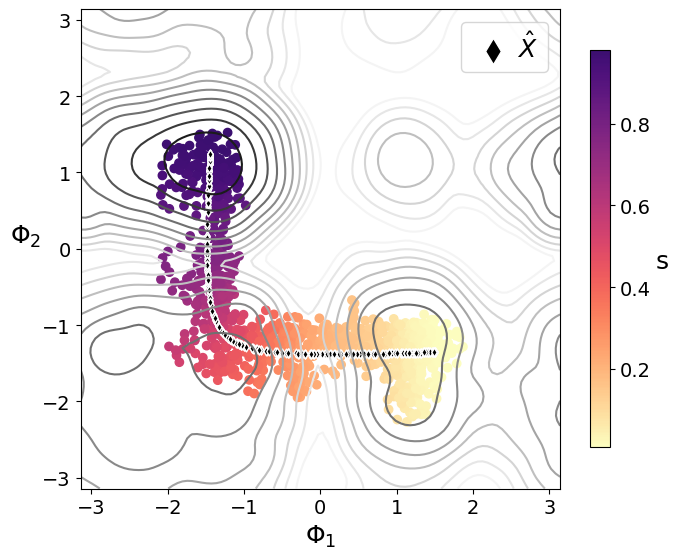

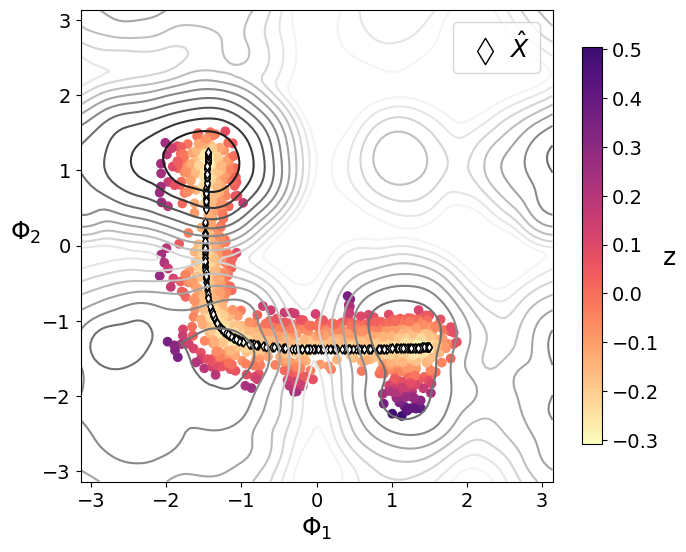

In [20]:
import matplotlib.colors as mcolors

input=model_datapoints
x_hat,s,d,dn=plumed_model.encode_decode(input)
x_hat=x_hat.detach().numpy()


input=training_datapoints
out=plumed_model(input)
s = out[:,0]
z = out[:,1]
s=s.detach().numpy()
z=z.detach().numpy()


magma = plt.colormaps["magma_r"] 
new_magma = mcolors.ListedColormap(magma(np.linspace(0.0, 0.8, 256)))  


fig, ax = plt.subplots(1, figsize=(7,7))
ax.contour(phi_grid, psi_grid, file_free_grid,levels, cmap='Greys_r')
contour2=plt.scatter(training_datapoints[:,0],training_datapoints[:,1],c=s[:],cmap=new_magma)
plt.scatter(x_hat[:,0], x_hat[:,1],color='black', s=20, marker='d',edgecolors='white',label=r'$\hat{X}$')

cbar = plt.colorbar(contour2,ax=ax, shrink=0.6)
cbar.set_label(r's', rotation=0, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$\Phi_1$',fontsize=18)
plt.ylabel(r'$\Phi_2$',fontsize=18,rotation=0,labelpad=12)
ax.set_aspect('equal')
legend = plt.legend(loc='upper right', fontsize=18, markerscale=3, handlelength=1.75, handletextpad=0.1)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, figsize=(7,7))
ax.contour(phi_grid, psi_grid, file_free_grid,levels, cmap='Greys_r')
contour2=plt.scatter(training_datapoints[:,0],training_datapoints[:,1],c=z[:],cmap=new_magma)
plt.scatter(x_hat[:,0], x_hat[:,1],color='white', s=20, marker='d',edgecolors='black',label=r'$\hat{X}$')

cbar = plt.colorbar(contour2,ax=ax, shrink=0.6)
cbar.set_label(r'z', rotation=0, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$\Phi_1$',fontsize=18)
plt.ylabel(r'$\Phi_2$',fontsize=18,rotation=0,labelpad=12)
ax.set_aspect('equal')
legend = plt.legend(loc='upper right', fontsize=18, markerscale=3, handlelength=1.75, handletextpad=0.1)
plt.tight_layout()
plt.show()

In [36]:
import plotly.graph_objects as go


fig = go.Figure(data=go.Scatter3d(
    x=training_datapoints[:,0],
    y=training_datapoints[:,1],
    z=training_datapoints[:,2],
    mode='markers',
    marker=dict(
        size=5,
        color=s,            
        colorscale='electric',  
        opacity=0.2,
        colorbar=dict(title=r's')
    )
))

fig.update_layout(
    scene=dict(
        xaxis=dict(backgroundcolor='#CCCCCC'),
        yaxis=dict(backgroundcolor='#CCCCCC'),
        zaxis=dict(backgroundcolor='#CCCCCC', gridcolor='rgba(0, 0, 0, 0)')
    )
)

fig.add_trace(go.Scatter3d(
    x=x_hat[:,0],
    y=x_hat[:,1],
    z=x_hat[:,2],
    mode='markers',
    marker=dict(
        size=10,
#        
        opacity=1
    ),
    name='xhat'
))


fig.update_layout(
    scene=dict(
        xaxis=dict(title=r'ϕ1'),
        yaxis=dict(title=r'ϕ2'),
        zaxis=dict(title=r'ϕ3')
    )
)

fig.show()


In [37]:
import plotly.graph_objects as go


fig = go.Figure(data=go.Scatter3d(
    x=training_datapoints[:,0],
    y=training_datapoints[:,1],
    z=training_datapoints[:,2],
    mode='markers',
    marker=dict(
        size=5,
        color=z,            
        colorscale='electric',  
        opacity=0.2,
        colorbar=dict(title=r'z')
    )
))

fig.update_layout(
    scene=dict(
        xaxis=dict(backgroundcolor='#CCCCCC'),
        yaxis=dict(backgroundcolor='#CCCCCC'),
        zaxis=dict(backgroundcolor='#CCCCCC', gridcolor='rgba(0, 0, 0, 0)')
    )
)

fig.add_trace(go.Scatter3d(
    x=x_hat[:,0],
    y=x_hat[:,1],
    z=x_hat[:,2],
    mode='markers',
    marker=dict(
        size=10,
        opacity=1
    ),
    name='xhat'
))


fig.update_layout(
    scene=dict(
        xaxis=dict(title=r'ϕ1'),
        yaxis=dict(title=r'ϕ2'),
        zaxis=dict(title=r'ϕ3')
    )
)

fig.show()


torch.Size([4096, 2])
torch.Size([4096, 4])
torch.Size([4096, 6])


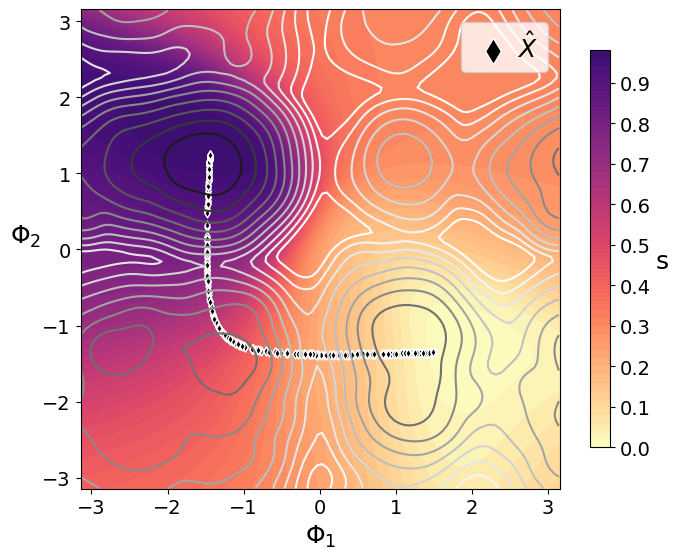

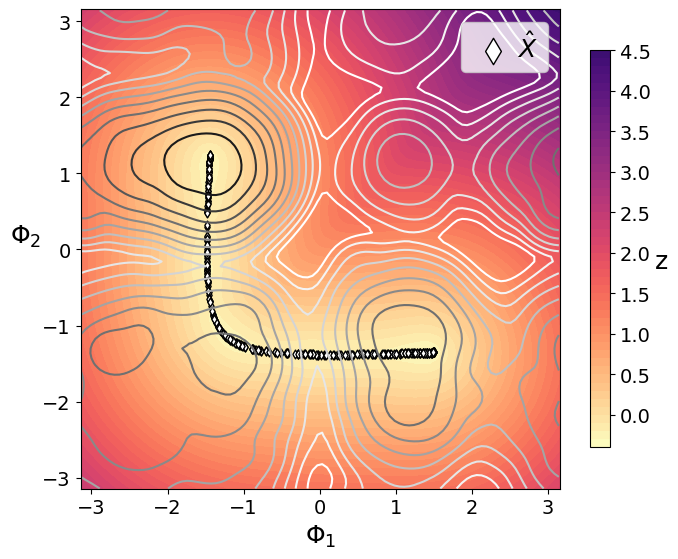

In [898]:
import matplotlib.colors as mcolors

input=model_datapoints
x_hat,s,d,dn=plumed_model.encode_decode(input)
x_hat=x_hat.detach().numpy()

x_range = np.arange(-np.pi, np.pi+0.05, 0.1)
y_range = np.arange(-np.pi, np.pi+0.05, 0.1)

x_grid, y_grid = np.meshgrid(x_range, y_range)

grid_points = np.column_stack((x_grid.flatten(), y_grid.flatten()))

sample_grid=torch.Tensor(grid_points)
fill=torch.ones(sample_grid.shape[0],4)
fill=torch.zeros(sample_grid.shape[0],4)
print(sample_grid.shape)
print(fill.shape)

input=torch.hstack((sample_grid,fill))
print(input.shape)
out=plumed_model(input)
s = out[:,0]
z = out[:,1]
s=s.detach().numpy()
z=z.detach().numpy()


grid_x = grid_points[:, 0].reshape(x_grid.shape)  
grid_y = grid_points[:, 1].reshape(x_grid.shape)  
grid_s = s.reshape(x_grid.shape)  
grid_z = z.reshape(x_grid.shape)  

magma = plt.colormaps["magma_r"] 
new_magma = mcolors.ListedColormap(magma(np.linspace(0.0, 0.8, 256)))  


fig, ax = plt.subplots(1, figsize=(7,7))
contour2 = ax.contourf(grid_x,grid_y,grid_s,50,cmap=new_magma)
ax.contour(phi_grid, psi_grid, file_free_grid,levels, cmap='Greys_r')
plt.scatter(x_hat[:,0], x_hat[:,1],color='black', s=20, marker='d',edgecolors='white',label=r'$\hat{X}$')
cbar = plt.colorbar(contour2,ax=ax, shrink=0.6)
cbar.set_label(r's', rotation=0, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$\Phi_1$',fontsize=18)
plt.ylabel(r'$\Phi_2$',fontsize=18,rotation=0,labelpad=12)
ax.set_aspect('equal')
legend = plt.legend(loc='upper right', fontsize=18, markerscale=3, handlelength=1.75, handletextpad=0.1)
plt.tight_layout()
plt.show()

fig, ax = plt.subplots(1, figsize=(7,7))
contour2 = ax.contourf(grid_x,grid_y,grid_z,50,cmap=new_magma)
ax.contour(phi_grid, psi_grid, file_free_grid,levels, cmap='Greys_r')
plt.scatter(x_hat[:,0], x_hat[:,1],color='white', s=20, marker='d',edgecolors='black',label=r'$\hat{X}$')
cbar = plt.colorbar(contour2,ax=ax, shrink=0.6)
cbar.set_label(r'z', rotation=0, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$\Phi_1$',fontsize=18)
plt.ylabel(r'$\Phi_2$',fontsize=18,rotation=0,labelpad=12)
ax.set_aspect('equal')
legend = plt.legend(loc='upper right', fontsize=18, markerscale=3, handlelength=1.75, handletextpad=0.1)
plt.tight_layout()
plt.show()

torch.Size([4096, 2])
torch.Size([4096, 4])
torch.Size([4096, 6])


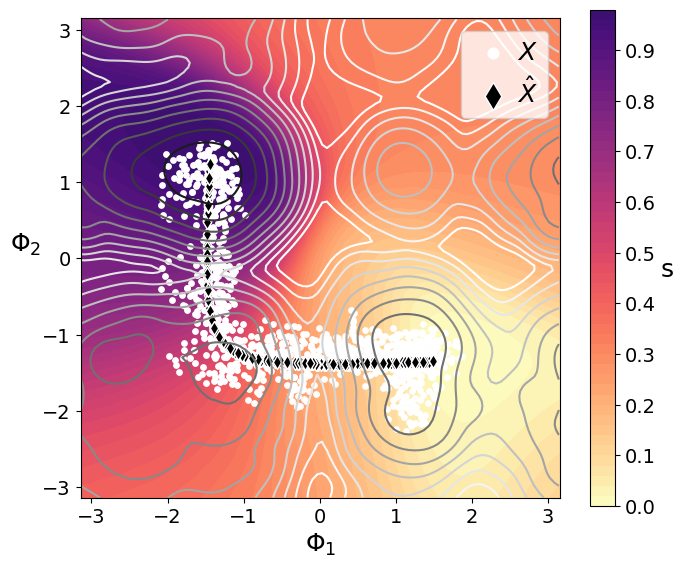

<Figure size 640x480 with 0 Axes>

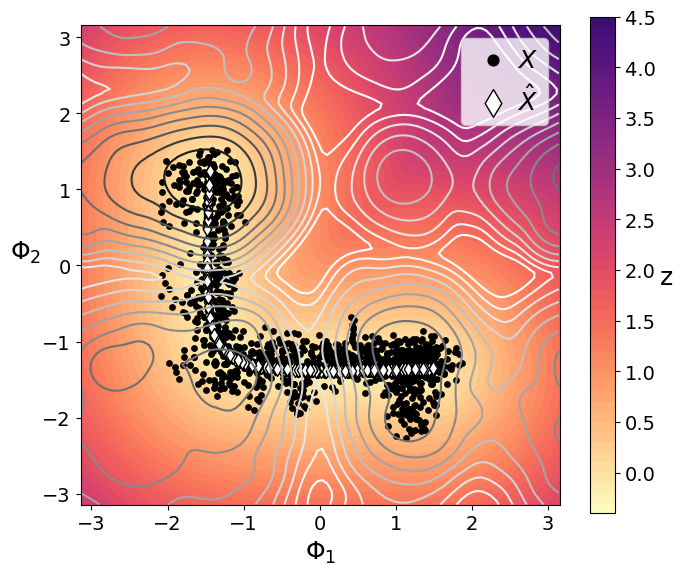

<Figure size 640x480 with 0 Axes>

In [899]:
import matplotlib.colors as mcolors

input=model_datapoints
x_hat,s,d,dn=plumed_model.encode_decode(input)
x_hat=x_hat.detach().numpy()

x_range = np.arange(-np.pi, np.pi+0.05, 0.1)
y_range = np.arange(-np.pi, np.pi+0.05, 0.1)

x_grid, y_grid = np.meshgrid(x_range, y_range)

grid_points = np.column_stack((x_grid.flatten(), y_grid.flatten()))

sample_grid=torch.Tensor(grid_points)
fill=torch.ones(sample_grid.shape[0],4)
fill=torch.zeros(sample_grid.shape[0],4)
print(sample_grid.shape)
print(fill.shape)

input=torch.hstack((sample_grid,fill))
print(input.shape)
out=plumed_model(input)
s = out[:,0]
z = out[:,1]
s=s.detach().numpy()
z=z.detach().numpy()

grid_x = grid_points[:, 0].reshape(x_grid.shape)  
grid_y = grid_points[:, 1].reshape(x_grid.shape)  
grid_s = s.reshape(x_grid.shape)  
grid_z = z.reshape(x_grid.shape)  

magma = plt.colormaps["magma_r"] 
new_magma = mcolors.ListedColormap(magma(np.linspace(0.0, 0.8, 256)))  


fig, ax = plt.subplots(1, figsize=(7,7))
contour2 = ax.contourf(grid_x,grid_y,grid_s,50,cmap=new_magma)
ax.contour(phi_grid, psi_grid, file_free_grid,levels, cmap='Greys_r')
plt.scatter(training_datapoints.detach().numpy()[:,0], training_datapoints.detach().numpy()[:,1],color='white', s=15, marker='o',label=r'$X$')
plt.scatter(x_hat[:,0], x_hat[:,1],color='black', s=50, marker='d',edgecolors='white',label=r'$\hat{X}$')
cbar = plt.colorbar(contour2,ax=ax, shrink=0.75)
cbar.set_label(r's', rotation=0, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$\Phi_1$',fontsize=18)
plt.ylabel(r'$\Phi_2$',fontsize=18,rotation=0,labelpad=12)
ax.set_aspect('equal')
legend = plt.legend(loc='upper right', fontsize=18, markerscale=2, handlelength=1.75, handletextpad=0.1)
plt.tight_layout()
plt.show()
plt.draw()
fig.savefig('Trialanine_RatchetDatapoints_s.svg')
fig.savefig('Trialanine_RatchetDatapoints_s.png', dpi=100)

fig, ax = plt.subplots(1, figsize=(7,7))
contour2 = ax.contourf(grid_x,grid_y,grid_z,50,cmap=new_magma)
ax.contour(phi_grid, psi_grid, file_free_grid,levels, cmap='Greys_r')

plt.scatter(training_datapoints.detach().numpy()[:,0], training_datapoints.detach().numpy()[:,1],color='black', s=15, marker='o',label=r'$X$')
plt.scatter(x_hat[:,0], x_hat[:,1],color='white', s=50, marker='d',edgecolors='black',label=r'$\hat{X}$')
cbar = plt.colorbar(contour2,ax=ax, shrink=0.75)
cbar.set_label(r'z', rotation=0, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$\Phi_1$',fontsize=18)
plt.ylabel(r'$\Phi_2$',fontsize=18,rotation=0,labelpad=12)
ax.set_aspect('equal')
legend = plt.legend(loc='upper right', fontsize=18, markerscale=2, handlelength=1.75, handletextpad=0.1)
plt.tight_layout()
plt.show()
plt.draw()
fig.savefig('Trialanine_RatchetDatapoints_z.svg')
fig.savefig('Trialanine_RatchetDatapoints_z.png', dpi=100)

In [40]:
#reinforcement learning step
#perform a short OPES using PYTORCH DeepLNE

In [41]:
%%bash 
cat > DeepLNE_3states/Production.mdp << EOF
; RUN PARAMETERS
integrator               = md
dt                       = 0.002
nsteps                   = 500000000               ;number of steps 1000000ps 1ms
nstxout                  = 500000                     ; high precision every 0.1ps
nstvout                  =     
nstlog                   = 500000
nstenergy                = 500000
nstxtcout                = 500000
xtc_grps                 = System     ;group(s) to write to xtc trajectory
energygrps               = System       ;group(s) to write to energy file 
                                                
;NEIGHBORING SEARCHING PARAMETERS
nstlist                  = 10                   ;Frequency to update the neighbor list (and the long-range forces, 
ns_type                  = Grid                 ;Make a grid in the box and only check atoms in neighboring grid cells 
                                                ;when constructing a new neighbor list every nstlist steps                                      
pbc                      = xyz                  ; Periodic boudary conditions in all the directions 
rlist                    = 1.0

;OPTIONS FOR ELECTROSTATICS AND VDW
cutoff-scheme            = Verlet
coulombtype              = PME 
pme_order                = 4                     ;cubic interpolation
fourierspacing           = 0.12 
rcoulomb                 = 1.0
vdw-type                 = Cut-off
rvdw                     = 1.0


;TEMPERATURE COUPLING
tcoupl                   = v-rescale            ;Temperature coupling
tc-grps                  = System
tau_t                    = 0.1
ref_t                    = 300

;DISPERSION CORRECTION
DispCorr                 = EnerPres             ; account for vdw cut-off

;PRESSURE COUPLING
Pcoupl                   = no                   ;NVT simulation

continuation             = yes
gen_vel                  = no                   ;Velocity generation
gen_temp                 = 300
gen_seed                 = -1

;OPTIONS FOR BONDS
lincs_iter               = 1
lincs_order              = 4
constraints              = h-bonds
EOF

In [42]:
%%bash 
gmx_mpi grompp -f DeepLNE_3states/Production.mdp -c ABMD_2Levels/stateA2.pdb -p topol.top -n index.ndx -o DeepLNE_3states/MD.tpr 

             :-) GROMACS - gmx grompp, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi grompp -f DeepLNE_3states/Production.mdp -c ABMD_2Levels/stateA2.pdb -p topol.top -n index.ndx -o DeepLNE_3states/MD.tpr

Ignoring obsolete mdp entry 'ns_type'
Replacing old mdp entry 'nstxtcout' by 'nstxout-compressed'
Replacing old mdp entry 'xtc_grps' by 'compressed-x-grps'
Generating 1-4 interactions: fudge = 0.5
Number of degrees of freedom in T-Coupling group System is 101.00

NOTE 1 [file DeepLNE_3states/Production.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off 

Setting the LD random seed to -545652897

Generated 3485 of the 3486 non-bonded parameter combinations

Generated 3486 of the 3486 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein'

turning H bonds into constraints...

The largest distance between excluded atoms is 0.397 nm

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.000 nm, buffer size 0.000 nm

Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 28x28x28, spacing 0.110 0.110 0.110

Estimate for the relative computational load of the PME mesh part: 0.95

This run will generate roughly 5 Mb of data


In [43]:
lines=[]
lines.append('MOLINFO STRUCTURE=molinfo_trialanine.pdb\n')

features=[]
lines.append('phi1: TORSION ATOMS=@phi-2\n')
lines.append('phi2: TORSION ATOMS=@phi-3\n')
lines.append('phi3: TORSION ATOMS=@phi-4\n')
lines.append('psi1: TORSION ATOMS=@psi-2\n')
lines.append('psi2: TORSION ATOMS=@psi-3\n')
lines.append('psi3: TORSION ATOMS=@psi-4\n')

lines.append('ene: ENERGY\n')

features.append('phi1')
features.append('phi2')
features.append('phi3')
features.append('psi1')
features.append('psi2')
features.append('psi3')



features = ','.join(features)
lines.append('model: PYTORCH_MODEL FILE=model_teacher.ptc ARG=%s \n' %features)

lines.append('OPES_METAD_EXPLORE ...\n')
lines.append('  LABEL=opes\n')
lines.append('  ARG=model.node-0\n')
lines.append('  FILE=Kernels.data\n')
lines.append('  STATE_RFILE=compressed.Kernels\n')
lines.append('  STATE_WFILE=compressed.Kernels\n')
lines.append('  PACE=500\n')
lines.append('  BARRIER=80\n')
lines.append('... OPES_METAD_EXPLORE\n')

lines.append('uwall_z: UPPER_WALLS ARG=model.node-1 KAPPA=500 AT=0.2\n')

lines.append('PRINT STRIDE=250 FILE=COLVAR ARG=* FMT=%7.4f\n')

lines.append('ENDPLUMED\n')

f = open("DeepLNE_3states/plumed.dat", "w")
for elem in lines:
    f.writelines(elem)
f.close()

In [44]:
!scp molinfo_trialanine.pdb DeepLNE_3states/

In [46]:
%%bash 
cat > DeepLNE_3states/run.sh << EOF
export OMP_NUM_THREADS=1
mpirun -n 1 gmx_mpi mdrun -deffnm MD -plumed plumed.dat -pin on -pinoffset 0 -notunepme -nsteps 2500000 -nb gpu &
EOF

In [185]:
!find . -type f -name "#*" -exec rm -rf {} +
!find . -type f -name "step*" -exec rm -rf {} +
!find . -type f -name "bck*" -exec rm -rf {} +

In [21]:
colvar=plumed.read_as_pandas("DeepLNE_3states/COLVAR")
colvar

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt8equal_toISD_ESaISt4pairIKSD_S4_EEE +++
+++ This error is expected if you are trying to load a kernel <=2.4
+++ Trying /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumed.so +++


time    phi1    phi2    phi3    psi1    psi2    psi3       ene  \
0         0.0  1.4538 -1.1037  1.0272 -1.2644  2.4749 -0.7364 -785.1878   
1         0.5  1.0470 -1.2597  1.1700 -0.4967  1.9288 -0.7458 -762.1956   
2         1.0  1.1778 -1.2909  1.1311 -0.6778  1.0911 -1.2633 -764.4412   
3         1.5  0.9313 -1.2656  0.9268 -1.8595  0.8333 -0.7449 -788.1268   
4         2.0  1.3659 -1.5429  1.0587 -0.8889  1.3980 -0.8454 -788.4586   
...       ...     ...     ...     ...     ...     ...     ...       ...   
9996   4998.0 -1.0985  1.2842 -2.4753  2.4124  0.8544  3.0690 -731.5149   
9997   4998.5 -1.4584  1.5813 -1.9034  2.7694  0.5850  2.4640 -738.3444   
9998   4999.0 -1.4890  1.5086 -2.9710  2.6026  1.3307  2.5476 -681.6994   
9999   4999.5 -1.4823  1.5229 -2.7408  2.6675  0.3944  2.6668 -710.4608   
10000  5000.0 -1.3951  1.4772 -2.5262  2.6647  0.1863  2.7614 -715.0070   

       model.node-0  model.node-1  opes.bias  opes.rct  opes.zed  opes.neff  \
0            0.0161        0.2073   -80.0000  -80.0000    1.0000     1.0000   
1            0.0665        0.0820   -80.0000  -80.0000    1.0000     1.0000   
2            0.0449        0.0465   -80.0000  -80.0000    1.0000     1.0000   
3            0.0848        0.0817   -80.0000  -80.0000    1.0000     1.0000   
4            0.0269        0.1447   -80.0000  -80.0000    1.0000     1.0000   
...             ...           ...        ...       ...       ...        ...   
9996         0.9679        0.3164    17.0199   92.9159    0.4259    23.9141   
9997         0.9789        0.3183    11.6196   92.9159    0.4259    23.9141   
9998         0.9750        0.2488    13.7143   92.9154    0.4258    23.9141   
9999         0.9770        0.2621    12.7578   92.9154    0.4258    23.9141   
10000        0.9762        0.2191    13.1733   92.9149    0.4258    23.9141   

       opes.nker  uwall_z.bias  uwall_z.force2  
0            0.0        0.0264         52.7346  
1            0.0        0.0000          0.0000  
2            0.0        0.0000          0.0000  
3            0.0        0.0000          0.0000  
4            0.0        0.0000          0.0000  
...          ...           ...             ...  
9996         8.0        6.7740      13547.9867  
9997         8.0        6.9949      13989.7240  
9998         8.0        1.1916       2383.2097  
9999         8.0        1.9255       3850.9426  
10000        8.0        0.1830        365.9972  

[10001 rows x 17 columns]

In [22]:
data_reinforcement=colvar.iloc[:,1:10].to_numpy()

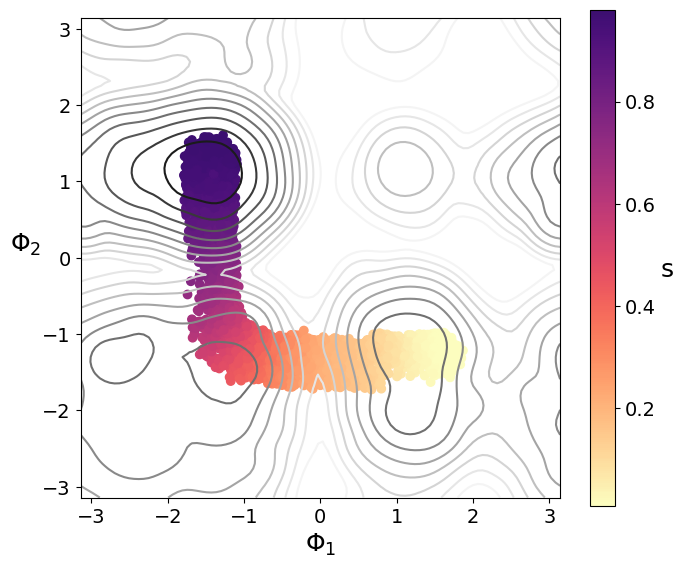

<Figure size 640x480 with 0 Axes>

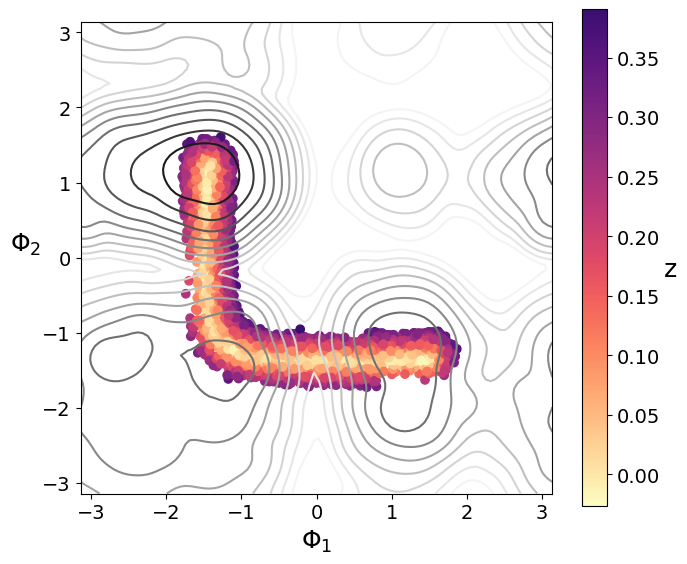

<Figure size 640x480 with 0 Axes>

In [23]:
import matplotlib.colors as mcolors

magma = plt.colormaps["magma_r"] 
new_magma = mcolors.ListedColormap(magma(np.linspace(0.0, 0.8, 256)))  


fig, ax = plt.subplots(1, figsize=(7,7))
ax.contour(phi_grid, psi_grid, file_free_grid,levels, cmap='Greys_r')
contour2=plt.scatter(data_reinforcement[:,0],data_reinforcement[:,1],c=data_reinforcement[:,7],cmap=new_magma)

cbar = plt.colorbar(contour2,ax=ax, shrink=0.75)
cbar.set_label(r's', rotation=0, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$\Phi_1$',fontsize=18)
plt.ylabel(r'$\Phi_2$',fontsize=18,rotation=0,labelpad=12)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()
plt.draw()
fig.savefig('Trialanine_reinforcement_s.svg')
fig.savefig('Trialanine_reinforcement_s.png', dpi=100)

fig, ax = plt.subplots(1, figsize=(7,7))
ax.contour(phi_grid, psi_grid, file_free_grid,levels, cmap='Greys_r')
contour2=plt.scatter(data_reinforcement[:,0],data_reinforcement[:,1],c=data_reinforcement[:,8],cmap=new_magma)

cbar = plt.colorbar(contour2,ax=ax, shrink=0.75)
cbar.set_label(r'z', rotation=0, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$\Phi_1$',fontsize=18)
plt.ylabel(r'$\Phi_2$',fontsize=18,rotation=0,labelpad=12)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()
plt.draw()
fig.savefig('Trialanine_reinforcement_z.svg')
fig.savefig('Trialanine_reinforcement_z.png', dpi=100)

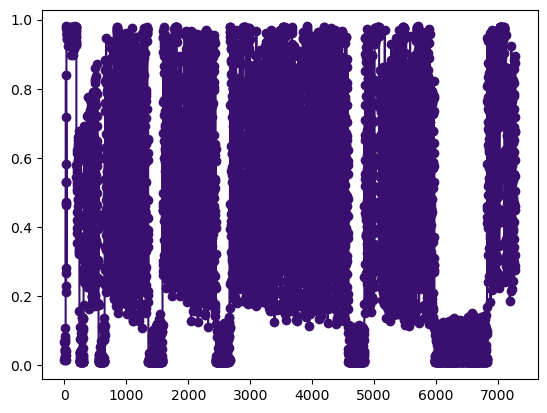

In [189]:
magma = plt.colormaps["magma_r"]
norm = mcolors.Normalize(vmin=0, vmax=10)

plt.plot(colvar['model.node-0'],'o-',color=magma(norm(8)))

In [190]:
import plotly.graph_objects as go

skip=1 

time=colvar['model.node-0'].to_numpy()[::skip]
phi1=colvar['phi1'].to_numpy()[::skip]
phi2=colvar['phi2'].to_numpy()[::skip]
phi3=colvar['phi3'].to_numpy()[::skip]


print(phi1.shape)
print(phi2.shape)
print(phi3.shape)
fig = go.Figure(data=go.Scatter3d(
    x=phi1,
    y=phi2,
    z=phi3,
    mode='markers',
    marker=dict(
        size=5,
        color=time,            
        colorscale='electric',  
        opacity=0.2,
        colorbar=dict(title=r'time')
    )
))

fig.update_layout(
    scene=dict(
        xaxis=dict(backgroundcolor='#CCCCCC'),
        yaxis=dict(backgroundcolor='#CCCCCC'),
        zaxis=dict(backgroundcolor='#CCCCCC', gridcolor='rgba(0, 0, 0, 0)')
    )
)

fig.update_layout(
    scene=dict(
        xaxis=dict(title=r'ϕ1'),
        yaxis=dict(title=r'ϕ2'),
        zaxis=dict(title=r'ϕ3')
    )
)

fig.show()


(7281,)
(7281,)
(7281,)


In [191]:
import plotly.graph_objects as go

skip=1 

time=colvar['model.node-1'].to_numpy()[::skip]
phi1=colvar['phi1'].to_numpy()[::skip]
phi2=colvar['phi2'].to_numpy()[::skip]
phi3=colvar['phi3'].to_numpy()[::skip]


print(phi1.shape)
print(phi2.shape)
print(phi3.shape)
fig = go.Figure(data=go.Scatter3d(
    x=phi1,
    y=phi2,
    z=phi3,
    mode='markers',
    marker=dict(
        size=5,
        color=time,           
        colorscale='electric',  
        opacity=0.2,
        colorbar=dict(title=r'time')
    )
))

fig.update_layout(
    scene=dict(
        xaxis=dict(backgroundcolor='#CCCCCC'),
        yaxis=dict(backgroundcolor='#CCCCCC'),
        zaxis=dict(backgroundcolor='#CCCCCC', gridcolor='rgba(0, 0, 0, 0)')
    )
)

fig.update_layout(
    scene=dict(
        xaxis=dict(title=r'ϕ1'),
        yaxis=dict(title=r'ϕ2'),
        zaxis=dict(title=r'ϕ3')
    )
)

fig.show()


(7281,)
(7281,)
(7281,)


In [24]:
colvar=plumed.read_as_pandas("DeepLNE_3states/COLVAR")
reinforcement_data=colvar.iloc[:,1:7].to_numpy()

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so" +++
+++ An error occurred. Message from dlopen(): /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumedKernel.so: undefined symbol: _ZN5torch3jit6MethodclESt6vectorIN3c106IValueESaIS4_EERKSt13unordered_mapINSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEES4_St4hashISD_ESt8equal_toISD_ESaISt4pairIKSD_S4_EEE +++
+++ This error is expected if you are trying to load a kernel <=2.4
+++ Trying /home/rizziv@farma.unige.ch/plumed2-2.9/src/lib/libplumed.so +++


(500, 6)


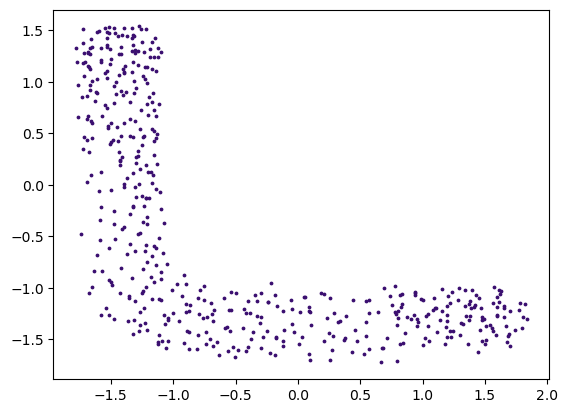

In [26]:
from skmatter.feature_selection import FPS

selector = FPS(n_to_select=500,initialize=0)

selector.fit(reinforcement_data[:,:3].T)
r_ndx=selector.selected_idx_
reinforcement_data_FPS = reinforcement_data[r_ndx]

print(reinforcement_data_FPS.shape)

norm = mcolors.Normalize(vmin=0, vmax=10)

plt.figure()
plt.scatter(reinforcement_data_FPS[:,0],reinforcement_data_FPS[:,1],color=magma(norm(8)),s=3,alpha=1)
plt.show()

In [27]:
student_training_datapoints=np.vstack((training_datapoints,reinforcement_data_FPS))
print(student_training_datapoints.shape)

(1500, 6)


In [28]:
device = torch.device("cpu")

ANN_architecture=[3]
AutoEncoder_architecture=[2] 

n_features=6
d_metric=3
n_neighbors=3
l=3.5e2

plumed_model = DeepLNE_CV(ANN_layers=ANN_architecture,
                   AutoEncoder_layers=AutoEncoder_architecture,
                   f=n_features,
                   d=d_metric,
                   n=n_neighbors,
                   ref=model_datapoints,
                   ref_z=model_datapoints_z,
                   act='Tanh',
                   z_lambda=l,
                   device=device)

plumed_model.load_state_dict(torch.load('./DeepLNE_3states/model_teacher.pt'), strict=False)

input_new=torch.Tensor(student_training_datapoints)

x_hat_new,s_new,d_new,dn_new = plumed_model.encode_decode(input_new)
x_hat_new=x_hat_new.detach().numpy()


out_new=plumed_model(input_new)
s_new = out_new[:,0]
z_new = out_new[:,1]
s_new=s_new.detach().numpy()
z_new=z_new.detach().numpy()

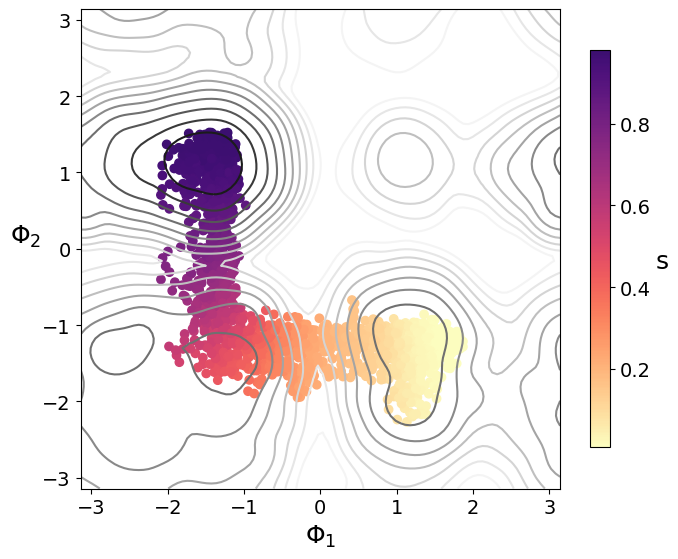

0.29508266


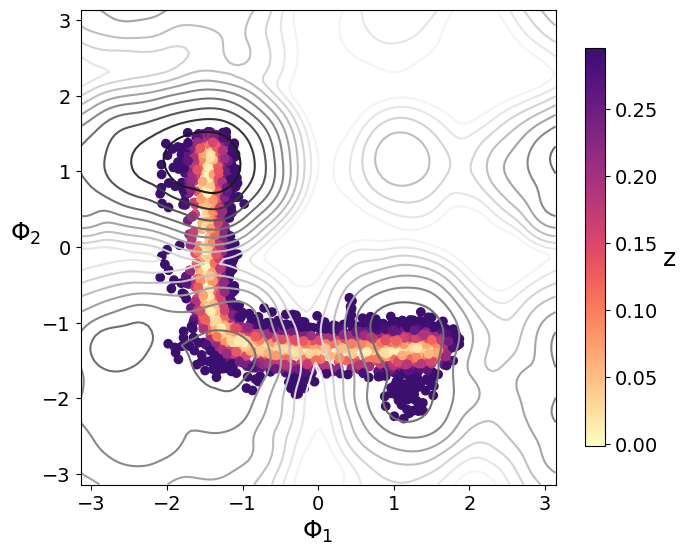

In [210]:
import matplotlib.colors as mcolors

magma = plt.colormaps["magma_r"] 
new_magma = mcolors.ListedColormap(magma(np.linspace(0.0, 0.8, 256)))  


fig, ax = plt.subplots(1, figsize=(7,7))
ax.contour(phi_grid, psi_grid, file_free_grid,levels, cmap='Greys_r')
contour2=plt.scatter(student_training_datapoints[:,0],student_training_datapoints[:,1],c=s_new,cmap=new_magma)

cbar = plt.colorbar(contour2,ax=ax, shrink=0.6)
cbar.set_label(r's', rotation=0, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$\Phi_1$',fontsize=18)
plt.ylabel(r'$\Phi_2$',fontsize=18,rotation=0,labelpad=12)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

ndx_inf = np.where(np.isinf(z_new))
ndx_nan = np.where(np.isnan(z_new))

max_val = np.nanmax(z_new[np.isfinite(z_new)])
print(max_val)

z_show=z_new
z_show[ndx_inf] = max_val
z_show[ndx_nan] = max_val

fig, ax = plt.subplots(1, figsize=(7,7))
ax.contour(phi_grid, psi_grid, file_free_grid,levels, cmap='Greys_r')
contour2=plt.scatter(student_training_datapoints[:,0],student_training_datapoints[:,1],c=z_show,cmap=new_magma)

cbar = plt.colorbar(contour2,ax=ax, shrink=0.6)
cbar.set_label(r'z', rotation=0, labelpad=8,fontsize=18)
cbar.ax.tick_params(labelsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel(r'$\Phi_1$',fontsize=18)
plt.ylabel(r'$\Phi_2$',fontsize=18,rotation=0,labelpad=12)
ax.set_aspect('equal')
plt.tight_layout()
plt.show()

In [32]:
!mkdir Benchmark

In [8]:
class DeepLNE_student(nn.Module):

    def __init__(self,
                ANN_layers: list,
                f: int,
                act: str):
        

        super(DeepLNE_student,self).__init__()
        
        # =======   LOSS  =======
        self.loss_mse = torch.nn.MSELoss()
        self.loss_smoothl1  =torch.nn.SmoothL1Loss(beta=1.35) #1.35
        

        # ======= BLOCKS =======
        
        self.n_features=f
        
        print('Numer of input features:',self.n_features)
         
        if act == 'ReLU':
            self.activationf=torch.nn.ReLU()
        if act == 'Tanh':
            self.activationf=torch.nn.Tanh()
        if act == 'Sigmoid':
            self.activationf=torch.nn.Sigmoid()
        if act == 'ELU':
            self.activationf=torch.nn.ELU()
        if act == 'Softplus':    
            self.activationf=torch.nn.Softplus()
        
        self.ANNlayers = []
        
        self.ANNlayers.append(torch.nn.Linear(self.n_features, ANN_layers[0]))
        self.ANNlayers.append(self.activationf)
        
        for i in range(len(ANN_layers) - 1):
            self.ANNlayers.append(torch.nn.Linear(ANN_layers[i], ANN_layers[i + 1]))
            self.ANNlayers.append(self.activationf)

        self.ANNlayers.append(torch.nn.Linear(ANN_layers[-1], 1))
        #self.ANNlayers.append(torch.nn.Sigmoid())
        
        
        self.ANN = torch.nn.Sequential(*self.ANNlayers)
        print('ANN architecture: ',self.ANN)
            
    
            
    def encode(self,x: torch.Tensor) -> torch.Tensor:
        x=self.ANN(x)
        return x
       
    def forward(self, x: torch.Tensor) -> torch.Tensor :
        out=self.encode(x)
        
        return out

In [34]:
#train student model s

feature_data_student=torch.Tensor(student_training_datapoints)
label_data_student=torch.Tensor(s_new)

print(torch.isnan(feature_data_student))
print(torch.isnan(label_data_student))

tensor([[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        ...,
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False]])
tensor([False, False, False,  ..., False, False, False])


In [35]:
if torch.isnan(label_data_student).any() or torch.isinf(label_data_student).any():
    label_data_student[torch.isnan(label_data_student) | torch.isinf(label_data_student)] = 0.5
            
feature_data_student=feature_data_student.detach().numpy() 
label_data_student=label_data_student.detach().numpy() 

print(feature_data_student.shape)
print(label_data_student.shape)

(1500, 6)
(1500,)


In [36]:
from torch.utils.data import TensorDataset, DataLoader

feature_data_student=torch.tensor(feature_data_student, dtype=torch.float32)
label_data_student=torch.tensor(label_data_student, dtype=torch.float32)

dataset = TensorDataset(feature_data_student, label_data_student)


In [37]:
from torch.utils.data import Subset
from torch.utils.data.dataset import random_split

torch.manual_seed(42)  
shuffle_dataset = True

dataset_size = len(dataset)
indices = list(range(dataset_size))
if shuffle_dataset:
    np.random.shuffle(indices)

# Split dataset into training and validation sets
train_size = int(0.8 * dataset_size)  # 80% for training, 20% for validation
val_size = dataset_size - train_size
train_indices, val_indices = indices[:train_size], indices[train_size:]
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)

# Define batch size for training
batch_size_train = 64

# Create DataLoader for training set
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True)

# Load entire validation dataset as one big batch
val_features = []
val_labels = []
for val_index in val_indices:
    feature, label = dataset[val_index]
    val_features.append(feature)
    val_labels.append(label)

val_features = torch.stack(val_features)  # Stack features into one big tensor
val_labels = torch.stack(val_labels)  # Stack labels into one big tensor

# Convert to tensor and move to device if necessary
val_features = val_features.to(device)
val_labels = val_labels.to(device)
val_features.shape

torch.Size([300, 6])

In [38]:
for batch_idx, (features, labels) in enumerate(train_loader):
    if batch_idx == 0 :
        print(features.shape)
        print(labels.shape)
batch_size_train*batch_idx

torch.Size([64, 6])
torch.Size([64])


1152

In [3]:
import numpy as np

def calculate_parameters(I, hidden_layers, O):
    parameters = 0
    input_nodes = I
    for hidden_nodes in hidden_layers:
        parameters += input_nodes * hidden_nodes + hidden_nodes
        input_nodes = hidden_nodes
    parameters += input_nodes * O + O
    return parameters

def find_architectures(I, O, n_parameters, tolerance=1):
    architectures = []
    max_hidden_layers = 4  
    n_parameters_set = set(n_parameters)
    memo = {}

    def backtrack(hidden_layers):
        if len(hidden_layers) > max_hidden_layers:
            return
        
        hidden_layers_tuple = tuple(hidden_layers)
        if hidden_layers_tuple in memo:
            params = memo[hidden_layers_tuple]
        else:
            params = calculate_parameters(I, hidden_layers, O)
            memo[hidden_layers_tuple] = params
        
        for target in n_parameters_set:
            if abs(params - target) <= tolerance:
                architectures.append((hidden_layers[:], params))
                n_parameters_set.remove(target)
                break
        
        if not n_parameters_set:
            return
        
        for nodes in range(1, 101):  
            hidden_layers.append(nodes)
            backtrack(hidden_layers)
            hidden_layers.pop()

    backtrack([])
    architectures.sort(key=lambda x: x[1])  
    return architectures

I = 6  # Example number of input nodes, change as needed
O = 1  # Example number of output nodes, change as needed
n_parameters = np.geomspace(16, 20000, num=10).astype(int).tolist()

architectures = find_architectures(I, O, n_parameters, tolerance=0)
all_architectures=[]
for arch, params in architectures:
    print(f"Hidden layers: {arch}, Parameters: {params}")
    all_architectures.append(arch)

Hidden layers: [1, 1, 2], Parameters: 16
Hidden layers: [1, 9], Parameters: 35
Hidden layers: [1, 1, 1, 22], Parameters: 78
Hidden layers: [1, 1, 54], Parameters: 172
Hidden layers: [1, 1, 9, 32], Parameters: 380
Hidden layers: [1, 9, 74], Parameters: 840
Hidden layers: [1, 1, 23, 72], Parameters: 1856
Hidden layers: [1, 1, 44, 87], Parameters: 4100
Hidden layers: [2, 12, 84, 92], Parameters: 9055
Hidden layers: [2, 97, 100, 97], Parameters: 20000


In [43]:
for a,ANN_architecture in enumerate(all_architectures):
    n_features=6

    model_student_s = DeepLNE_student(ANN_layers=ANN_architecture,
                       f=n_features,
                       act='Tanh').to(device)


    optimizer = optim.Adam(model_student_s.parameters(), lr=0.001)
    
    device = torch.device("cuda")
    model_student_s.to(device)  

    track_train = []
    track_val = []
    best_val_loss = float('inf')  

    num_epochs = 1001
    for epoch in range(num_epochs):
        train_loss = 0.0
        for batch_idx, (features, labels) in enumerate(train_loader):
            # Prepare input and target data
            x = features.to(device)  
            y = labels.to(device) 

            out_student = model_student_s.forward(x).flatten()

            T=1e0
            loss =model_student_s.loss_smoothl1(out_student, y)/T**2

            #L2 regularization
            for param in model.parameters():
                loss += 1e-6 * torch.norm(param, 2)


            # Backward Pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item() * x.size(0)

        train_loss = train_loss / batch_idx
        track_train.append(train_loss)

        # Validation phase
        model_student_s.eval()  # Set the model to evaluation mode
        val_loss = 0.0
        with torch.no_grad():

            val_x = val_features.to(device)
            val_y = val_labels.to(device)

            val_out_student = model_student_s.forward(val_x).flatten()

            loss =model_student_s.loss_smoothl1(val_out_student, val_y)/T**2


        val_loss += loss.item() * val_x.size(0)

        track_val.append(val_loss)

        if epoch % 100 == 0:
            print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(epoch, train_loss, val_loss))

            # Save the best model based on validation loss
            if val_loss < best_val_loss:
                best_val_loss = val_loss
                torch.save(model_student_s.state_dict(), 'Benchmark/model_params_student_s_ladder5_%s.pt' %a)

Numer of input features: 6
ANN architecture:  Sequential(
  (0): Linear(in_features=6, out_features=1, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1, out_features=1, bias=True)
  (3): Tanh()
  (4): Linear(in_features=1, out_features=2, bias=True)
  (5): Tanh()
  (6): Linear(in_features=2, out_features=1, bias=True)
)
Epoch: 0 	Training Loss: 3.202380 	Validation Loss: 12.516312
Epoch: 100 	Training Loss: 0.020265 	Validation Loss: 0.089808
Epoch: 200 	Training Loss: 0.019729 	Validation Loss: 0.084366
Epoch: 300 	Training Loss: 0.019949 	Validation Loss: 0.089267
Epoch: 400 	Training Loss: 0.019963 	Validation Loss: 0.084178
Epoch: 500 	Training Loss: 0.020172 	Validation Loss: 0.086002
Epoch: 600 	Training Loss: 0.020030 	Validation Loss: 0.085740
Epoch: 700 	Training Loss: 0.019647 	Validation Loss: 0.083765
Epoch: 800 	Training Loss: 0.020038 	Validation Loss: 0.083874
Epoch: 900 	Training Loss: 0.019686 	Validation Loss: 0.084433
Epoch: 1000 	Training Loss: 0.019928 	Validat

Epoch: 900 	Training Loss: 0.018097 	Validation Loss: 0.085607
Epoch: 1000 	Training Loss: 0.018982 	Validation Loss: 0.090459
Numer of input features: 6
ANN architecture:  Sequential(
  (0): Linear(in_features=6, out_features=2, bias=True)
  (1): Tanh()
  (2): Linear(in_features=2, out_features=12, bias=True)
  (3): Tanh()
  (4): Linear(in_features=12, out_features=84, bias=True)
  (5): Tanh()
  (6): Linear(in_features=84, out_features=92, bias=True)
  (7): Tanh()
  (8): Linear(in_features=92, out_features=1, bias=True)
)
Epoch: 0 	Training Loss: 2.398609 	Validation Loss: 6.865320
Epoch: 100 	Training Loss: 0.021408 	Validation Loss: 0.094968
Epoch: 200 	Training Loss: 0.020724 	Validation Loss: 0.087930
Epoch: 300 	Training Loss: 0.019350 	Validation Loss: 0.081227
Epoch: 400 	Training Loss: 0.017246 	Validation Loss: 0.080438
Epoch: 500 	Training Loss: 0.015599 	Validation Loss: 0.087524
Epoch: 600 	Training Loss: 0.014319 	Validation Loss: 0.079358
Epoch: 700 	Training Loss: 0.014

In [ ]:
def dumpPlumed(filename, model, activation='tanh'):
    # Extract weights and biases from the model
    weights = [param.detach().numpy().T for param in model.parameters() if len(param.size()) == 2]
    biases = [param.detach().numpy() for param in model.parameters() if len(param.size()) == 1]

    # Flatten and concatenate weights and biases
    par = np.hstack([param.flatten() for param in weights + biases])

    # Reshape weights and biases according to the original shapes
    n = 0
    for i in range(len(weights)):
        weights[i] = np.reshape(par[n:n+np.prod(weights[i].shape)], weights[i].shape)
        n += np.prod(weights[i].shape)
    for i in range(len(biases)):
        biases[i] = np.reshape(par[n:n+np.prod(biases[i].shape)], biases[i].shape)
        n += np.prod(biases[i].shape)

    # Write weights, biases, and activations to the file
    with open(filename, "w") as f:
        for i in range(len(weights)):
            ni, no = weights[i].shape
            print("#! FIELDS " + " ".join(["w"+str(j) for j in range(ni)]), file=f)
            for j in range(no):
                print(' '.join(map(str, weights[i][:,j])), file=f)
            print("#! FIELDS " + " ".join(["b"+str(j) for j in range(no)]), file=f)
            print(' '.join(map(str, biases[i])), file=f)
            if i+1 < len(weights):
                print("#! FIELDS " + " ".join(["activation"+str(j) for j in range(no)]), file=f)
                print(' '.join([activation]*no), file=f)

In [46]:
for a,ANN_architecture in enumerate(all_architectures):
    
    n_features=6

    model_student_s = DeepLNE_student(ANN_layers=ANN_architecture,
                       f=n_features,
                       act='Tanh').to(device)
    
    model_student_s=model_student_s.cpu()
    model_student_s.load_state_dict(torch.load('Benchmark/model_params_student_s_ladder5_%s.pt' %a), strict=False)
    
    dumpPlumed('./Benchmark/ann_multi_s_ladder5_%s.dat' %a, model_student_s, 'tanh')

Numer of input features: 6
ANN architecture:  Sequential(
  (0): Linear(in_features=6, out_features=1, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1, out_features=1, bias=True)
  (3): Tanh()
  (4): Linear(in_features=1, out_features=2, bias=True)
  (5): Tanh()
  (6): Linear(in_features=2, out_features=1, bias=True)
)
Numer of input features: 6
ANN architecture:  Sequential(
  (0): Linear(in_features=6, out_features=1, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1, out_features=9, bias=True)
  (3): Tanh()
  (4): Linear(in_features=9, out_features=1, bias=True)
)
Numer of input features: 6
ANN architecture:  Sequential(
  (0): Linear(in_features=6, out_features=1, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1, out_features=1, bias=True)
  (3): Tanh()
  (4): Linear(in_features=1, out_features=1, bias=True)
  (5): Tanh()
  (6): Linear(in_features=1, out_features=22, bias=True)
  (7): Tanh()
  (8): Linear(in_features=22, out_features=1, bias=True)
)
Numer of input featu

In [47]:
%%bash 
gmx_mpi grompp -f OPES/Production.mdp -c ./ABMD_2Levels/stateA1.pdb -p topol.top -n index.ndx -o Benchmark/MD.tpr 

             :-) GROMACS - gmx grompp, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine
Command line:
  gmx_mpi grompp -f OPES/Production.mdp -c ./ABMD_2Levels/stateA1.pdb -p topol.top -n index.ndx -o Benchmark/MD.tpr

Ignoring obsolete mdp entry 'ns_type'
Replacing old mdp entry 'nstxtcout' by 'nstxout-compressed'
Replacing old mdp entry 'xtc_grps' by 'compressed-x-grps'
Generating 1-4 interactions: fudge = 0.5
Number of degrees of freedom in T-Coupling group System is 101.00

NOTE 1 [file OPES/Production.mdp]:
  The optimal PME mesh load for parallel simulations is below 0.5
  and for highly parallel simulations between 0.25 and 0.33,
  for higher performance, increase the cut-off and the PME grid spacing.


Setting the LD random seed to -137387041

Generated 3485 of the 3486 non-bonded parameter combinations

Generated 3486 of the 3486 1-4 parameter combinations

Excluding 3 bonded neighbours molecule type 'Protein'

turning H bonds into constraints...

The largest distance between excluded atoms is 0.383 nm

Determining Verlet buffer for a tolerance of 0.005 kJ/mol/ps at 300 K

Calculated rlist for 1x1 atom pair-list as 1.000 nm, buffer size 0.000 nm

Set rlist, assuming 4x4 atom pair-list, to 1.000 nm, buffer size 0.000 nm

Note that mdrun will redetermine rlist based on the actual pair-list setup
Calculating fourier grid dimensions for X Y Z
Using a fourier grid of 28x28x28, spacing 0.110 0.110 0.110

Estimate for the relative computational load of the PME mesh part: 0.95

This run will generate roughly 5 Mb of data


In [4]:
for a,ANN_architecture in enumerate(all_architectures):
    lines=[]
    lines.append('MOLINFO STRUCTURE=molinfo_trialanine.pdb\n')

    features=[]
    lines.append('phi1: TORSION ATOMS=@phi-2\n')
    lines.append('phi2: TORSION ATOMS=@phi-3\n')
    lines.append('phi3: TORSION ATOMS=@phi-4\n')
    lines.append('psi1: TORSION ATOMS=@psi-2\n')
    lines.append('psi2: TORSION ATOMS=@psi-3\n')
    lines.append('psi3: TORSION ATOMS=@psi-4\n')
    lines.append('ene: ENERGY\n')

    features.append('phi1')
    features.append('phi2')
    features.append('phi3')
    features.append('psi1')
    features.append('psi2')
    features.append('psi3')

    features = ','.join(features)
    lines.append('model_s: MULTI_ANN ARG=%s PARAMETERS=ann_multi_s_ladder5_%s.dat groupby=6 \n' %(features,a))


    lines.append('OPES_METAD ...\n')
    lines.append('  LABEL=opes\n')
    lines.append('  ARG=model_s\n')
    lines.append('  FILE=Kernels.data\n')
    lines.append('  STATE_RFILE=compressed.Kernels\n')
    lines.append('  STATE_WFILE=compressed.Kernels\n')
    lines.append('  PACE=1000\n')
    lines.append('  BARRIER=80\n')
    lines.append('  SIGMA=0.1\n')
    lines.append('... OPES_METAD\n')

    
    lines.append('PRINT STRIDE=250 FILE=COLVAR ARG=* FMT=%7.4f\n')

    lines.append('ENDPLUMED\n')

    f = open("Benchmark/plumed_DeepLNE_ladder5_%s.dat" %a, "w")
    for elem in lines:
        f.writelines(elem)
    f.close()

In [51]:
!scp MultiANN_tanh.cpp ./Benchmark
!scp ./DeepLNE_3states/model_teacher.ptc ./Benchmark
!scp molinfo_trialanine.pdb ./Benchmark

In [52]:
lines=[]
lines.append('MOLINFO STRUCTURE=molinfo_trialanine.pdb\n')

features=[]
lines.append('phi1: TORSION ATOMS=@phi-2\n')
lines.append('phi2: TORSION ATOMS=@phi-3\n')
lines.append('phi3: TORSION ATOMS=@phi-4\n')
lines.append('psi1: TORSION ATOMS=@psi-2\n')
lines.append('psi2: TORSION ATOMS=@psi-3\n')
lines.append('psi3: TORSION ATOMS=@psi-4\n')

lines.append('ene: ENERGY\n')

features.append('phi1')
features.append('phi2')
features.append('phi3')
features.append('psi1')
features.append('psi2')
features.append('psi3')



features = ','.join(features)
lines.append('model: PYTORCH_MODEL FILE=model_teacher.ptc ARG=%s \n' %features)

lines.append('OPES_METAD_EXPLORE ...\n')
lines.append('  LABEL=opes\n')
lines.append('  ARG=model.node-0\n')
lines.append('  FILE=Kernels.data\n')
lines.append('  STATE_RFILE=compressed.Kernels\n')
lines.append('  STATE_WFILE=compressed.Kernels\n')
lines.append('  PACE=500\n')
lines.append('  BARRIER=80\n')
lines.append('... OPES_METAD_EXPLORE\n')

lines.append('uwall_z: UPPER_WALLS ARG=model.node-1 KAPPA=500 AT=0.2\n')

lines.append('PRINT STRIDE=250 FILE=COLVAR ARG=* FMT=%7.4f\n')

lines.append('ENDPLUMED\n')

f = open("Benchmark/plumed.dat", "w")
for elem in lines:
    f.writelines(elem)
f.close()

In [53]:
%%bash 
cat > Benchmark/run.sh << EOF
export OMP_NUM_THREADS=4
mpirun -n 1 gmx_mpi mdrun -deffnm MD -plumed plumed.dat -pin on -pinoffset 0 -notunepme -nsteps 50000 -nb gpu &
EOF

In [54]:
%%bash
mv Benchmark/MD.log Benchmark/MD_pytorch_teacher.log

In [5]:
import subprocess
import os

var = 5

os.makedirs('Benchmark', exist_ok=True)

for outer_iteration in range(10):
    for iteration in range(3):
        script_content = f"""#!/bin/bash
export OMP_NUM_THREADS=1
mpirun -n 1 gmx_mpi mdrun -deffnm MD -plumed plumed_DeepLNE_ladder{var}_{outer_iteration}.dat -pin on -pinoffset 0 -notunepme -nsteps 50000 -nb gpu
"""
        with open('Benchmark/run.sh', 'w') as file:
            file.write(script_content)

        os.chmod('Benchmark/run.sh', 0o755)

        subprocess.run(['bash', 'run.sh'], cwd='Benchmark', check=True)

        log_filename = f'Benchmark/MD_ladder{var}_{outer_iteration}_{iteration}.log'
        if os.path.exists('Benchmark/MD.log'):
            os.rename('Benchmark/MD.log', log_filename)


             :-) GROMACS - gmx mdrun, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine/Benchmark
Command line:
  gmx_mpi mdrun -deffnm MD -plumed plumed_DeepLNE_ladder5_0.dat -pin on -pinoffset 0 -notunepme -nsteps 50000 -nb gpu

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/frohlkin@farma.unige.ch/Software/plumed2/src/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/frohlkin@farma.unige.ch/Software/plumed2/src/lib/libplumedKernel.so" +++

Back Off! I just backed up MD.log to ./#MD.log.4#
Reading file MD.tpr, VERSION 2022.5-plumed_2.10.0_dev (single precision)
Overriding nsteps with value passed on the command line: 50000 steps, 100 ps
Changin


Back Off! I just backed up MD.xtc to ./#MD.xtc.8#

Back Off! I just backed up MD.trr to ./#MD.trr.8#

Back Off! I just backed up MD.edr to ./#MD.edr.8#
starting mdrun 'alanine tripeptide in vacuum'
50000 steps,    100.0 ps.

Writing final coordinates.

Back Off! I just backed up MD.gro to ./#MD.gro.7#

               Core t (s)   Wall t (s)        (%)
       Time:        2.149        2.149      100.0
                 (ns/day)    (hour/ns)
Performance:     4020.826        0.006

GROMACS reminds you: "We haven't the money, so we've got to think." (Ernest Rutherford)

             :-) GROMACS - gmx mdrun, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine/Benchmark
Command line:
  gmx_mpi mdrun -deffnm MD -plumed


Back Off! I just backed up MD.xtc to ./#MD.xtc.13#

Back Off! I just backed up MD.trr to ./#MD.trr.13#

Back Off! I just backed up MD.edr to ./#MD.edr.13#
starting mdrun 'alanine tripeptide in vacuum'
50000 steps,    100.0 ps.

Writing final coordinates.

Back Off! I just backed up MD.gro to ./#MD.gro.12#

               Core t (s)   Wall t (s)        (%)
       Time:        2.189        2.189      100.0
                 (ns/day)    (hour/ns)
Performance:     3947.476        0.006

GROMACS reminds you: "In a talk you have a choice: You can make one point or no points." (Paul Sigler)

             :-) GROMACS - gmx mdrun, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine/Benchmark
Command line:
  gmx_mpi mdrun

             :-) GROMACS - gmx mdrun, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine/Benchmark
Command line:
  gmx_mpi mdrun -deffnm MD -plumed plumed_DeepLNE_ladder5_4.dat -pin on -pinoffset 0 -notunepme -nsteps 50000 -nb gpu

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/frohlkin@farma.unige.ch/Software/plumed2/src/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/frohlkin@farma.unige.ch/Software/plumed2/src/lib/libplumedKernel.so" +++
Reading file MD.tpr, VERSION 2022.5-plumed_2.10.0_dev (single precision)
Overriding nsteps with value passed on the command line: 50000 steps, 100 ps
Changing nstlist from 10 to 100, rlist from 1 to 1


1 GPU


Back Off! I just backed up MD.xtc to ./#MD.xtc.22#

Back Off! I just backed up MD.trr to ./#MD.trr.22#

Back Off! I just backed up MD.edr to ./#MD.edr.22#
starting mdrun 'alanine tripeptide in vacuum'
50000 steps,    100.0 ps.

Writing final coordinates.

Back Off! I just backed up MD.gro to ./#MD.gro.21#

               Core t (s)   Wall t (s)        (%)
       Time:        2.251        2.251      100.0
                 (ns/day)    (hour/ns)
Performance:     3838.729        0.006

GROMACS reminds you: "Baby, It Aint Over Till It's Over" (Lenny Kravitz)

             :-) GROMACS - gmx mdrun, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine/Benchmark
Command line:
  gmx_mpi mdrun -deffnm MD -plumed plumed_Dee

             :-) GROMACS - gmx mdrun, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine/Benchmark
Command line:
  gmx_mpi mdrun -deffnm MD -plumed plumed_DeepLNE_ladder5_7.dat -pin on -pinoffset 0 -notunepme -nsteps 50000 -nb gpu

+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/frohlkin@farma.unige.ch/Software/plumed2/src/lib/libplumedKernel.so" +++
+++ Loading the PLUMED kernel runtime +++
+++ PLUMED_KERNEL="/home/frohlkin@farma.unige.ch/Software/plumed2/src/lib/libplumedKernel.so" +++
Reading file MD.tpr, VERSION 2022.5-plumed_2.10.0_dev (single precision)
Overriding nsteps with value passed on the command line: 50000 steps, 100 ps
Changing nstlist from 10 to 100, rlist from 1 to 1


1 GPU


Back Off! I just backed up MD.xtc to ./#MD.xtc.31#

Back Off! I just backed up MD.trr to ./#MD.trr.31#

Back Off! I just backed up MD.edr to ./#MD.edr.31#
starting mdrun 'alanine tripeptide in vacuum'
50000 steps,    100.0 ps.

Writing final coordinates.

Back Off! I just backed up MD.gro to ./#MD.gro.30#

               Core t (s)   Wall t (s)        (%)
       Time:        3.302        3.302      100.0
                 (ns/day)    (hour/ns)
Performance:     2616.645        0.009

GROMACS reminds you: "Everybody Lie Down On the Floor and Keep Calm" (KLF)

             :-) GROMACS - gmx mdrun, 2022.5-plumed_2.10.0_dev (-:

Executable:   /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda/bin/gmx_mpi
Data prefix:  /home/rizziv@farma.unige.ch/programs/gromacs-2022.5/install_single_cuda
Working dir:  /home/frohlkin@farma.unige.ch/Projects/TransitionPathSampling_DeepLNE/Publication_Toymodels/Trialanine/Benchmark
Command line:
  gmx_mpi mdrun -deffnm MD -plumed plumed_D

In [6]:
!find . -type f -name "#*" -exec rm -rf {} +
!find . -type f -name "step*" -exec rm -rf {} +
!find . -type f -name "bck*" -exec rm -rf {} +

In [7]:
filename='MD_pytorch_teacher.log'
with open('./Benchmark/'+filename, 'r') as file:
    for line in file:
        if line.startswith('Performance:'):
            performance_pytorch = float(line.split()[1])

print(performance_pytorch)             
filenames=[]
performance_values_mean=[]
performance_values_std=[]
for r in range(10):
    
    performance_values=[]
    for iteration in range(3):
        filenames.append('MD_ladder5_%s_%s.log' %(r,iteration))

            
        for filename in filenames:
            with open('./Benchmark/'+filename, 'r') as file:
                for line in file:
                    if line.startswith('Performance:'):
                        performance_value = float(line.split()[1])
                        performance_values.append(performance_value)
        
    performance_values_mean.append(np.mean(performance_values))
    performance_values_std.append(np.std(performance_values))
        
        


201.063


In [10]:
device = torch.device("cuda")

nparameters=[]

for a,ANN_architecture in enumerate(all_architectures):
    
    n_features=6

    model_student_s = DeepLNE_student(ANN_layers=ANN_architecture,
                       f=n_features,
                       act='Tanh').to(device)
    
    model_student_s=model_student_s.cpu()
    model_student_s.load_state_dict(torch.load('Benchmark/model_params_student_s_ladder5_%s.pt' %a), strict=False)

    weights = [param for param in model_student_s.parameters() if len(param.size()) == 2]
    biases = [param for param in model_student_s.parameters() if len(param.size()) == 1]

    flattened_params1 = np.concatenate([param.detach().numpy().T.flatten() for param in weights])
    flattened_params2 =  np.concatenate([param.flatten().detach().numpy() for param in biases])
    flattened_params = np.hstack((flattened_params1,flattened_params2))
    nparameters.append(len(flattened_params))
    

Numer of input features: 6
ANN architecture:  Sequential(
  (0): Linear(in_features=6, out_features=1, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1, out_features=1, bias=True)
  (3): Tanh()
  (4): Linear(in_features=1, out_features=2, bias=True)
  (5): Tanh()
  (6): Linear(in_features=2, out_features=1, bias=True)
)
Numer of input features: 6
ANN architecture:  Sequential(
  (0): Linear(in_features=6, out_features=1, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1, out_features=9, bias=True)
  (3): Tanh()
  (4): Linear(in_features=9, out_features=1, bias=True)
)
Numer of input features: 6
ANN architecture:  Sequential(
  (0): Linear(in_features=6, out_features=1, bias=True)
  (1): Tanh()
  (2): Linear(in_features=1, out_features=1, bias=True)
  (3): Tanh()
  (4): Linear(in_features=1, out_features=1, bias=True)
  (5): Tanh()
  (6): Linear(in_features=1, out_features=22, bias=True)
  (7): Tanh()
  (8): Linear(in_features=22, out_features=1, bias=True)
)
Numer of input featu

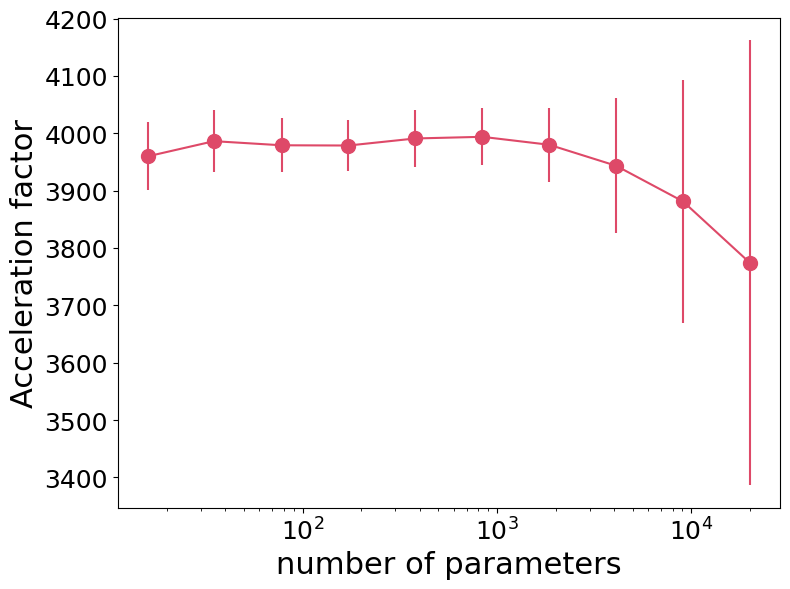

In [11]:
import matplotlib.colors as mcolors
norm = mcolors.Normalize(vmin=0, vmax=10)


magma = plt.colormaps["magma_r"] 
new_magma = mcolors.ListedColormap(magma(np.linspace(0.0, 0.8, 256)))  

fig, ax = plt.subplots(1, figsize=(8,6), dpi=100)
plt.plot(nparameters,performance_values_mean,'o',color=new_magma(0.5),markersize=10)
plt.errorbar(nparameters,performance_values_mean,yerr=performance_values_std,color=new_magma(0.5),markersize=10)
plt.ylabel(r'Acceleration factor', fontsize=22)
plt.xlabel('number of parameters', fontsize=22)

plt.xticks(fontsize=18)
plt.yticks(fontsize=18)
plt.xscale('log')


plt.tight_layout()
plt.show()

In [12]:
np.save('Benchmark/Trialanine_nparameters.npy', nparameters)
np.save('Benchmark/Trialanine_mean.npy',performance_values_mean)
np.save('Benchmark/Trialanine_std.npy',performance_values_std)